# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Для определения рыночной стоимости объектов недвижимости проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Чтение данных и изучение общей информации

In [194]:
%pip install missingno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import missingno as msno
import warnings

Note: you may need to restart the kernel to use updated packages.


In [195]:
data = pd.read_csv('A:/Python/Dataset/real_estate_data.csv', sep='\t')

In [196]:
# Получим общее представление о типах данных, их количестве, названиях колонок
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [197]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


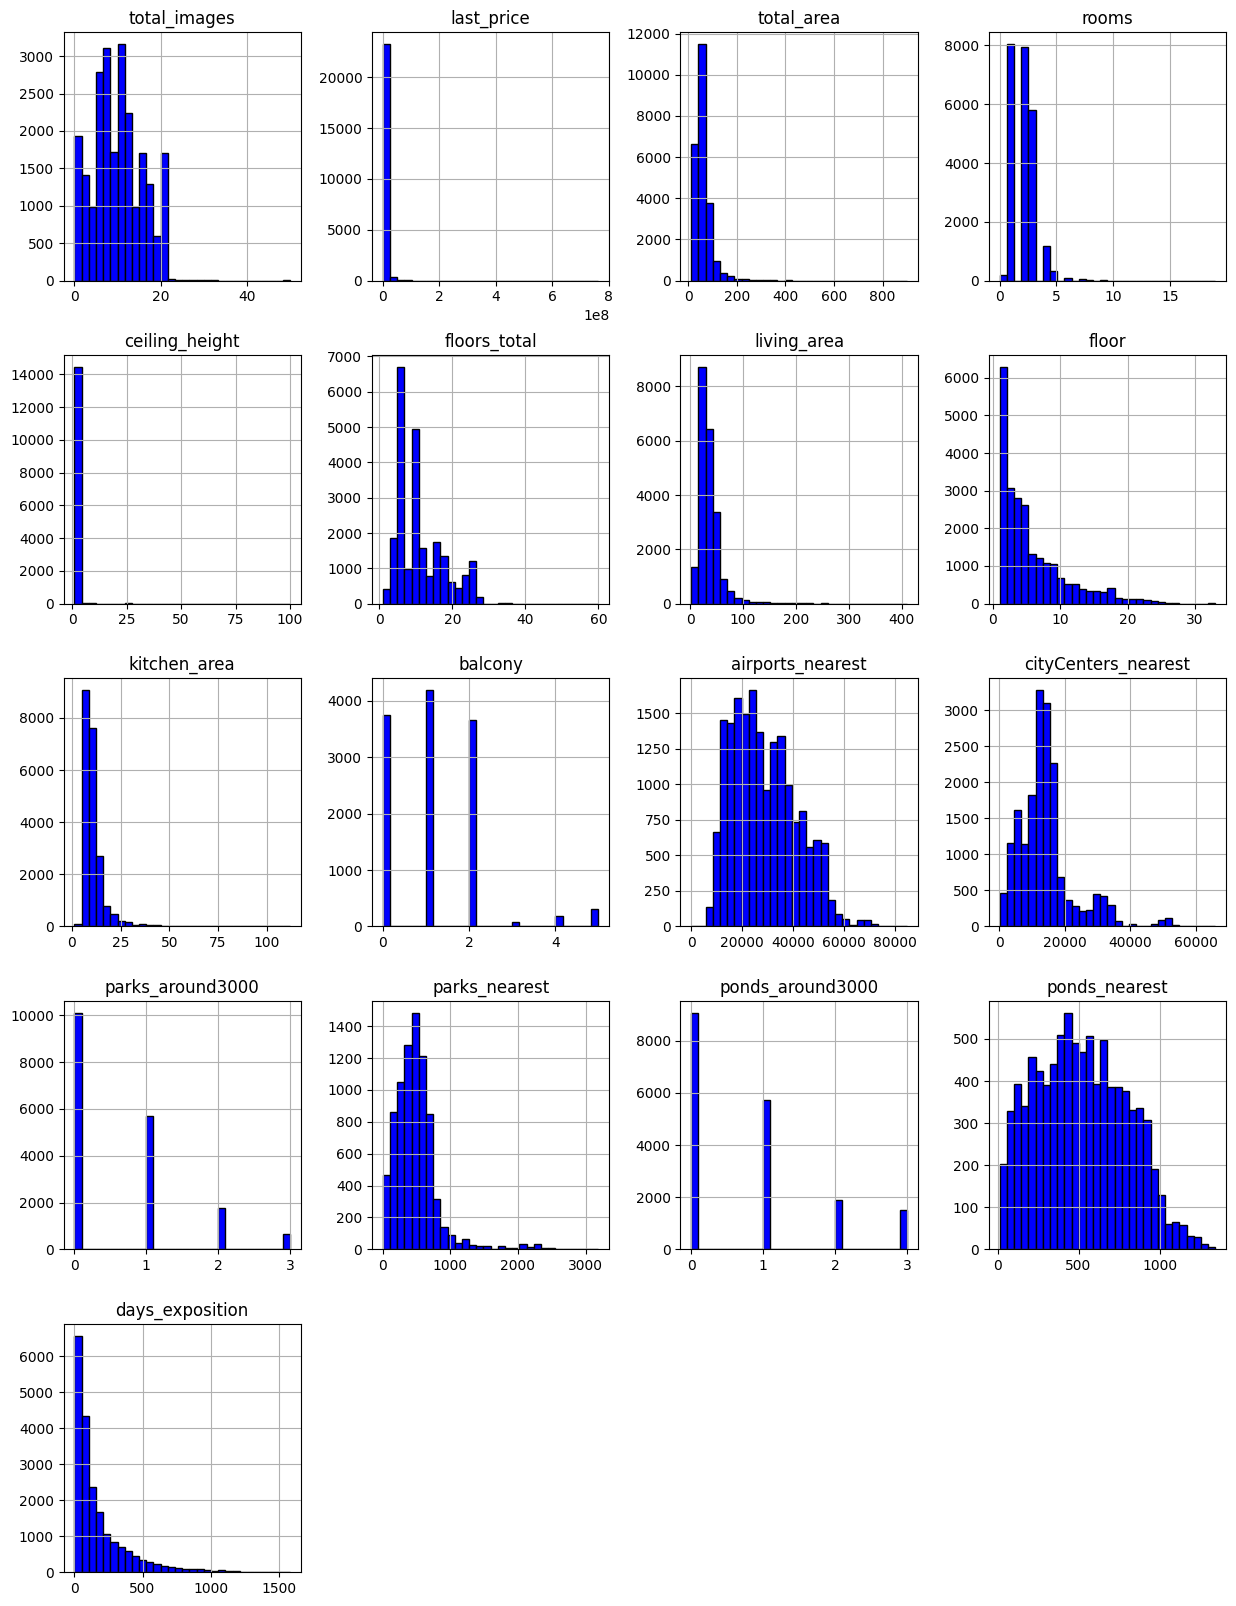

In [198]:
# Общий обзор данных
data.hist(bins=30,
          figsize=(15, 20),
          color='blue',
          edgecolor='black')
plt.show()

Выше получены общие сведения о данных. Так мы можем "познакомиться" с данными: узнать названия столбцов, тип и формат данных, сколько значений содержится в каждом столбце. Гистограммы позволяют визуально оценить данные по численным параметрам.

### Предобработка данных
<a id='data_processing'></a>

#### Поиск и устранение пропущенных значений

In [199]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

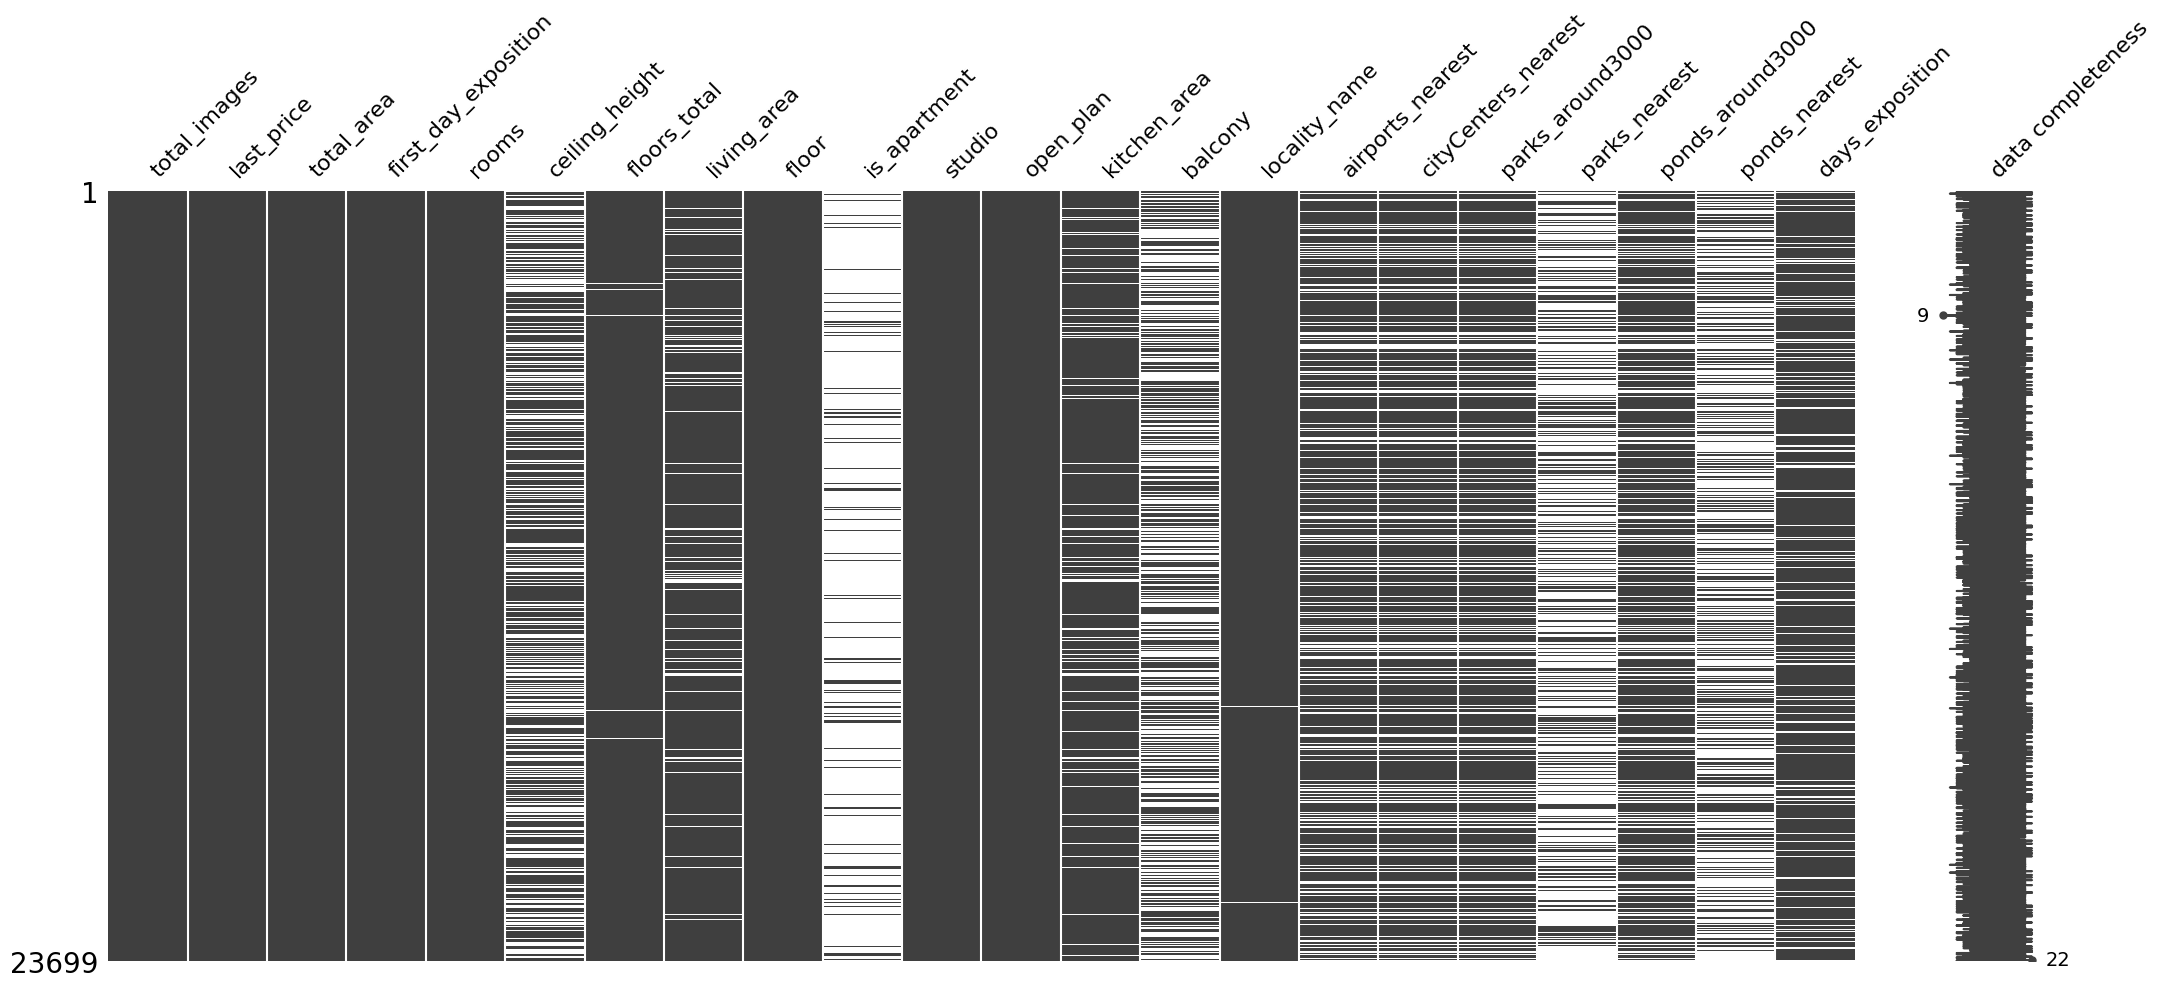

In [200]:
# Визуализация пропущенных значений.Черным цветом выделяется наличие данных, отсутствие данных - белый цвет.
msno.matrix(data, labels=True)
plt.show()

Устраним пропуски там, где это возможно.
- Высота потолков, скорее всего, пропущена пользователем, заполнявшим информацию. Лучше не заполнять эти пропуски, так как нет четкого знания, какой высоты могут быть потолки в разных квартирах.
- Пропуски в количестве этажей оставим, так как их мало,а информации для заполнения нет.
- Пропуски жилой площади можно заменить медианным значением жилой площади в квартирах с равным количеством комнат (проверить, сильно ли это изменит распределение).
- В столбце, указывающем, является ли недвижимость апартаментами, много пропусков, так как, скорее всего, пользователи не заполняли это поле, если их недвижимость не является апартаментами. Можно заменить отсутствующие значения на False. Однако тип данных в столбце - object, необходимо заменить его на bool для удобства обработки.
- Пропущенное количество балконов можно заменить 0, так как эта информация, скорее всего, заполнялась пользователем, и, если балконов нет, ее могли пропустить.
- Пропуски площади кухни можно заменить медианным значением площади кухни в квартирах с равным количеством комнат (проверить, сильно ли это изменит распределение).
- Пропусков в указании локации 49 - заменим на "Нет названия"
- Пропуски в расстоянии до ближайшего аэропорта и центра города можно заменить медианным расстоянием для того же населенного пункта ('locality_name') с проверкой, изменилось ли распределение. Если другого такого же населенного пункта нет в списке,  оставим пропуски.
- Пропуске в колонке с парками поблизости, как и с прудами, скорее всего, означают, что парков/прудов нет, поэтому заменим их 0.
- Пропуски в колонке с расстояниями до ближайших парков и прудов связаны с отсутствием поблизости парков и прудов. Оставим пропуски, так как мы можем сказать, что расстояние больше 3000 м, но приблизительное расстояние прикинуть не получится.
- Пропуски в днях размещения объявления оставим, так как, скорее всего, в дни закрытия объявлений произошла техническая ошибка на сервере.

##### Обработка пропусков в столбце "Является ли апартаментами?"

In [201]:
# В столбце is_apartment заменим пропуски значением False и поменяем тип данных, потому что столбец содержит строки True/False
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')
data['is_apartment'].isna().sum()

0

In [202]:
data['is_apartment'].head()

0    False
1    False
2    False
3    False
4    False
Name: is_apartment, dtype: bool

##### Замена пропусков в столбце "Жилая площадь"

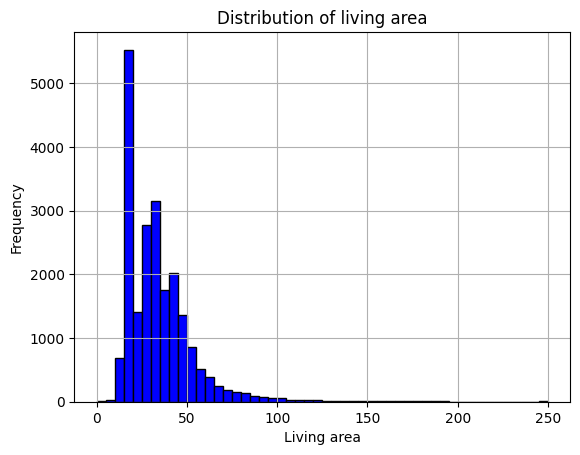

In [203]:
# Для контроля замены пропусков в столбце с жилой площадью посмотрим на распределение данных в этом столбце.
data['living_area'].hist(bins=50,
                         range=(0, 250),
                         color='blue',
                        edgecolor='black')
plt.title('Distribution of living area')
plt.xlabel('Living area')
plt.ylabel('Frequency')
plt.show()

In [204]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

В данных присутствуют объекты с количеством комнат = 0. Там, где это не студия, заменим количество комнат 1 для дальнейших расчетов.

In [205]:
data.loc[data['rooms'] == 0][['studio', 'total_area','living_area', 'kitchen_area']].head(20)

,studio,total_area,living_area,kitchen_area
144,True,27.00,15.50,NaN
349,False,25.00,17.00,NaN
440,True,27.11,24.75,NaN
508,False,34.40,24.30,NaN
608,True,25.00,NaN,NaN
697,True,24.10,17.50,NaN
716,True,17.00,12.00,NaN
780,False,26.10,NaN,NaN
839,False,35.00,15.00,NaN
946,False,23.00,18.00,NaN


In [206]:
# Заменим количество комнат 1 для дальнейших расчетов там, где количество комнат равно 0 и не квартира не является студией.
data.loc[(data['rooms'] == 0) & (data['studio'] == False), 'rooms'] = 1

In [207]:
# В столбце жилой площади living_area заменим отсутствующие значения на медианное по квартирам с тем же количеством комнат.
warnings.filterwarnings("ignore", category=RuntimeWarning)
def replace_with_median(parametr, value):
    """"Replaces NaN values in value datum with median datum with the same parametr.
    If there are no values to count median, continue without processing this value"""
    for quantity in data[parametr].unique():
        median_value = data.loc[data[parametr] == quantity, value].median()
        
        if np.isnan(median_value):
            #data.loc[(data[parametr] == quantity) & (data[value].isna()), value] = np.nan
            continue
        else:
            data.loc[(data[parametr] == quantity) & (data[value].isna()), value] = median_value

        
replace_with_median('rooms','living_area')

In [208]:
# Проверим, что пропусков не осталось.
data['living_area'].isna().sum()

0

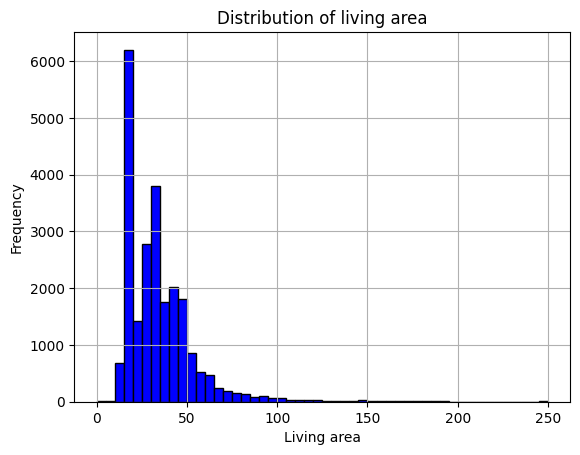

In [209]:
# Убедимся, что заменили пропуски корректно.
data['living_area'].hist(bins=50,
                         range=(0, 250),
                         color='blue',
                         edgecolor='black')
plt.title('Distribution of living area')
plt.xlabel('Living area')
plt.ylabel('Frequency')
plt.show()

In [210]:
data['living_area'].describe()

count    23699.000000
mean        34.321914
std         21.700678
min          2.000000
25%         18.400000
50%         30.300000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64

In [211]:
# Проверим связь между жилой площадью и общей площадью, она должна быть линейной и прямой.
data['living_area'].corr(data['total_area'])

0.9094396170012338

Пропуски в жилой площади устранены по медианному значению в категории квартир с тем же количеством комнат.
Распределение данных не нарушено, есть связь с жилой площадью.

#### Замена пропусков в столбце "Площадь кухни"

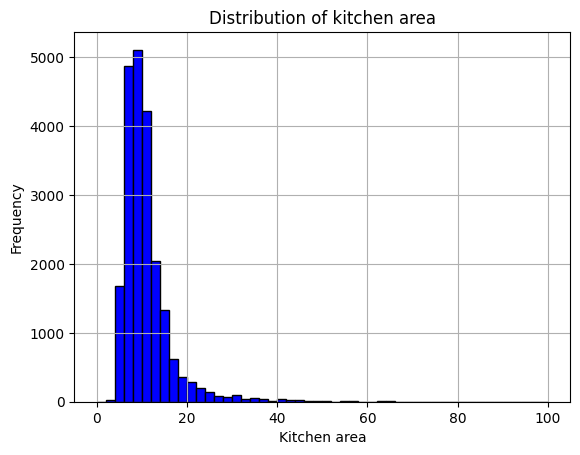

In [212]:
# Заменим пропуски для площади кухни kitchen_area так же, как и для жилой площади.
# Для контроля качества посмотрим на распределение данных.
data['kitchen_area'].hist(bins=50,
                          range=(0, 100),
                          color='blue',
                          edgecolor='black')
plt.title('Distribution of kitchen area')
plt.xlabel('Kitchen area')
plt.ylabel('Frequency')
plt.show()


In [213]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [214]:
# Заменим пропуски в площади кухонь студий 0, так как там нет отдельно выделенных помещений=кухонь,
# и мы не можем утверждать точно, есть ли в студии зона приготовления пищи. Заменяем отдельно, чтобы избежать ошибки далее.
data.loc[(data['kitchen_area'].isna()) & (data['studio'] == True), 'kitchen_area'] = 0

In [215]:
# В столбце площади кухни kitchen_area заменим отсутствующие значения на медианное по квартирам с тем же количеством комнат.
replace_with_median('rooms','kitchen_area')

In [216]:
# Проверим, что пропусков не осталось.
data['kitchen_area'].isna().sum()

0

In [217]:
data['kitchen_area'].describe()

count    23699.000000
mean        10.394335
std          5.701706
min          0.000000
25%          7.200000
50%          9.000000
75%         11.500000
max        112.000000
Name: kitchen_area, dtype: float64

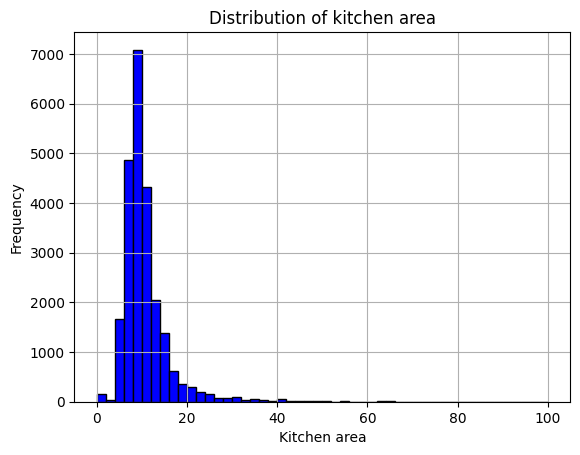

In [218]:
data['kitchen_area'].hist(bins=50,
                          range=(0, 100),
                          color='blue',
                          edgecolor='black')
plt.title('Distribution of kitchen area')
plt.xlabel('Kitchen area')
plt.ylabel('Frequency')
plt.show()

Пропуски в площади кухни устранены по медианному значению в категории квартир с тем же количеством комнат. Распределение данных не нарушено.

#### Замена пропусков в столбце "Количество балконов"

In [219]:
# Заменим пропуски в столбце налиичия балконов balcony на 0 (предполагаем, что отсутсвие значения связано с отсутствием балкона)
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

#### Замена пропусков в столбце "Населенный пункт" и устранение дубликатов для оптимизации дальнейшей обработки

In [220]:
# Замена пропусков NaN в названии населенных пунктов на "нет названия", так как нет подходящего значения для замены.
data.loc[data['locality_name'].isna(), 'locality_name'] = 'нет названия'
data['locality_name'].isna().sum()

0

In [221]:
data['locality_name'].value_counts()

Санкт-Петербург               15721
посёлок Мурино                  522
посёлок Шушары                  440
Всеволожск                      398
Пушкин                          369
                              ...  
посёлок Белоостров                1
деревня Пельгора                  1
коттеджный поселок Счастье        1
деревня Нижняя                    1
поселок Ромашки                   1
Name: locality_name, Length: 365, dtype: int64

В названиях населенных пунктов 'locality_name' возможно большое число повторений и неточностей в связи с написанием типа населенного пункта, с ошибками и опечатками. Для удобства приведем все названия к единому виду - географическое название в нижнем регистре.

In [222]:
data['locality_name'] = data['locality_name'].str.lower()

In [223]:
data['locality_name'].sort_values().unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'городской поселок большая ижора',
       'городской поселок янино-1', 'городской посёлок будогощь',
       'городской посёлок виллози', 'городской посёлок лесогорский',
       'городской посёлок мга', 'городской посёлок назия',
       'городской посёлок новоселье', 'городской посёлок павлово',
       'городской посёлок рощино', 'городской посёлок свирьстрой',
       'городской посёлок советский', 'городской посёлок фёдоровское',
       'городской посёлок янино-1', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка

In [224]:
len(data['locality_name'].sort_values().unique())

365

In [225]:
# Переведем данные в строковый тип, чтобы далее применить метод разделения строк
data['locality_name'] = data['locality_name'].astype('str')

In [226]:
# Для устранения неявных дубликатов уберем типы населенных пунктов.
words_to_remove = ['садовое товарищество', 'поселок городского типа', 'посёлок городского типа', 
    'городской посёлок', 'поселок станции', 'коттеджный поселок', 'коттеджный',
    'садоводческое некоммерческое товарищество', 'посёлок при железнодорожной станции', 
    'поселок', 'посёлок', 'деревня', 'село', 'город', 'ской', 'ского типа', 'пансионат','станции']


def remove_words(name):
    """"Function removing locality type
    """
    if name == 'ивангород':
        return name
    for word in words_to_remove:
        name = name.replace(word, '').strip()
    return name


data['locality_name'] = data['locality_name'].apply(remove_words)

In [227]:
data['locality_name'].sort_values().unique()

array(['агалатово', 'александровская', 'алексеевка', 'аннино', 'аро',
       'барышево', 'батово', 'бегуницы', 'белогорка', 'белоостров',
       'бокситогорск', 'большая вруда', 'большая ижора',
       'большая пустомержа', 'большие колпаны', 'большое рейзино',
       'большой сабск', 'бор', 'борисова грива', 'бугры', 'будогощь',
       'ваганово', 'важины', 'вартемяги', 'вахнова кара', 'вещево',
       'виллози', 'вознесенье', 'возрождение', 'войсковицы', 'войскорово',
       'володарское', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'вырица', 'выскатка', 'высокоключевой', 'высоцк', 'гаврилово',
       'гарболово', 'гатчина', 'гладкое', 'глажево', 'глебычево',
       'глинка', 'гончарово', 'горбунки', 'гостилицы', 'громово',
       'дзержинского', 'дружная горка', 'дружноселье', 'дубровка',
       'елизаветино', 'ефимовский', 'жил', 'жилок', 'житково', 'завод',
       'заклинье', 'заневка', 'запорожское', 'зеленогорск', 'зелёный бор',
       'зимитицы', 'ивангород', 'извара',

In [228]:
data['locality_name'].replace({'кингисеппский': 'кингисепп', 'сапёрное': 'сапёрный', 'кузьмоловский': 'кузьмолово', 'коммунары' : 'коммунар'},
                              inplace=True)

In [229]:
len(data['locality_name'].unique())

302

После удаления неявных дубликатов получилось 302 уникальных названия, включая неизвестные населенные пункты.

#### Замена пропусков в столбцах расстояния до "Ближайший аэропорт / Центр города"

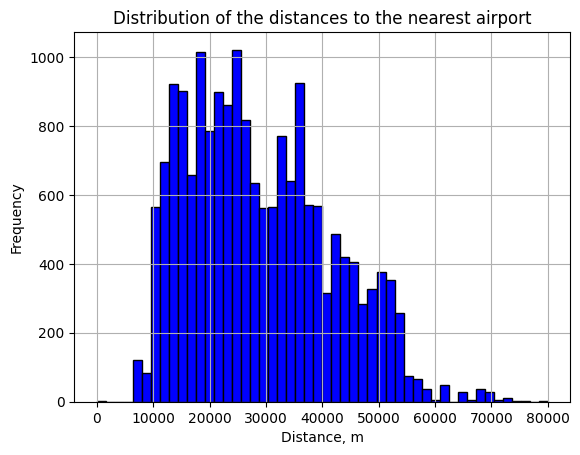

In [230]:
# Оценим распределение данных по расстоянию до аэропорта
data['airports_nearest'].hist(bins=50,
                              range=(0, 80000),
                              color='blue',
                              edgecolor='black')
plt.title('Distribution of the distances to the nearest airport')
plt.xlabel('Distance, m')
plt.ylabel('Frequency')
plt.show()

In [231]:
(data[(data['airports_nearest'] > 50000) & (data['airports_nearest'] < 55000)]
 [['airports_nearest','locality_name']].groupby('locality_name')['airports_nearest'].count())

locality_name
левашово             1
лисий нос            1
ломоносов            1
мурино               2
парголово          263
песочный             2
санкт-петербург    575
сестрорецк          49
Name: airports_nearest, dtype: int64

In [232]:
data['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [233]:
# Замена пропусков расстояния до ближайшего аэропорта
replace_with_median('locality_name','airports_nearest')
            
    
data['airports_nearest'].isna().sum()

4827

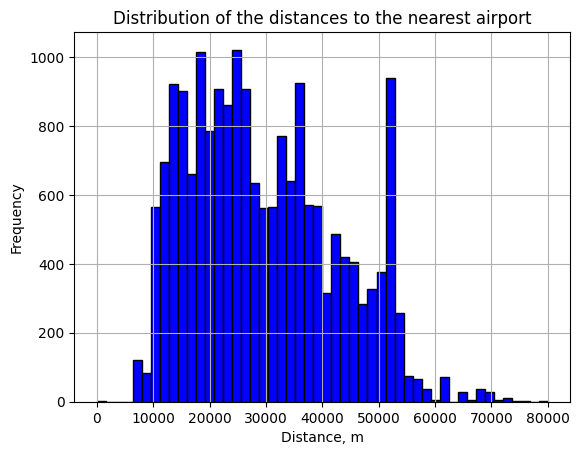

In [234]:
# Посмотрим на результат
data['airports_nearest'].hist(bins=50,
                              range=(0, 80000),
                              color='blue',
                              edgecolor='black')
plt.title('Distribution of the distances to the nearest airport')
plt.xlabel('Distance, m')
plt.ylabel('Frequency')
plt.show()

In [235]:
(data[(data['airports_nearest'] > 50000) & (data['airports_nearest'] < 55000)]
 [['airports_nearest','locality_name']].groupby('locality_name')['airports_nearest'].count())

locality_name
левашово             1
лисий нос            1
ломоносов            1
мурино             590
парголово          263
песочный             2
санкт-петербург    575
сестрорецк          49
Name: airports_nearest, dtype: int64

В данных появился выброс на расстоянии 50-53 км от аэропорта. Это связано с появлением данных для Мурино.

In [236]:
# Проверим пропуски. Они должны остаться для населенных пунктов, где расстояния были пропущены, медиану рассчитать не удалось.
data['airports_nearest'].isna().sum()

4827

In [237]:
data['airports_nearest'].describe()

count    18872.000000
mean     29531.920358
std      13061.270056
min          0.000000
25%      18849.000000
50%      27179.000000
75%      38745.250000
max      84869.000000
Name: airports_nearest, dtype: float64

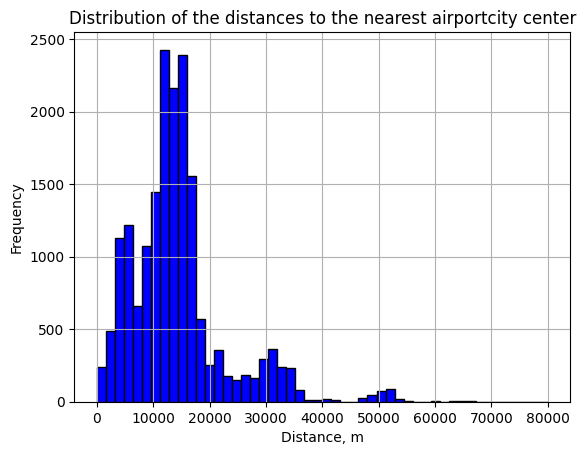

In [238]:
# Оценим распределение данных по расстоянию до центра города
data['cityCenters_nearest'].hist(bins=50,
                                 range=(0, 80000),
                                 color='blue',
                                 edgecolor='black')
plt.title('Distribution of the distances to the nearest airportcity center')
plt.xlabel('Distance, m')
plt.ylabel('Frequency')
plt.show()

In [239]:
data['cityCenters_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [240]:
# Замена пропусков в столбцах расстояния до центра города
replace_with_median('locality_name','cityCenters_nearest')
            
data['cityCenters_nearest'].isna().sum()

4827

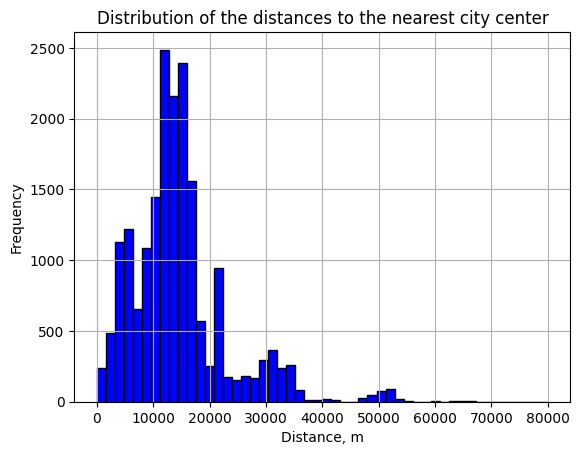

In [241]:
data['cityCenters_nearest'].hist(bins=50,
                                 range=(0, 80000),
                                 color='blue',
                                 edgecolor='black')
plt.title('Distribution of the distances to the nearest city center')
plt.xlabel('Distance, m')
plt.ylabel('Frequency')
plt.show()

In [242]:
# Проверим пропуски
data['cityCenters_nearest'].isna().sum()

4827

In [243]:
data['cityCenters_nearest'].describe()

count    18872.000000
mean     14458.352957
std       8598.259993
min        181.000000
25%       9484.750000
50%      13266.000000
75%      16771.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Выбран вариант замены пропусков медианным расстоянием до аэропорта медианным растоянием для каждого населенного пункта.
Остутствующие значения медиан (для населенных пунктов с 1 объектом недвижимости) привели к необходимости оставить 4827 пропущеных значения.


#### Замена пропусков в столбцах "Количество парков / прудов в пределах 3 км" и "Расстояние до ближайшего парка/пруда"

Предположим, что пропуски в столбцах parks_around3000 и ponds_around3000 связаны с их отсутствием. Тогда заменим пропуски 0.

In [244]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

In [245]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

Проверим гипотезу о том, что пропуски в расстояниях до ближайших парков и прудов есть только там, где нет парков поблизости.

In [246]:
if data \
.query('parks_around3000 == 0 | parks_around3000.isna()')['parks_nearest'] \
.isna().sum() == data['parks_nearest'].isna().sum():
    print(True)

True


In [247]:
if data \
.query('ponds_around3000 == 0 | ponds_around3000.isna()')['ponds_nearest'] \
.isna().sum() == data['ponds_nearest'].isna().sum():
    print(True)

True


Действительно, все пропущенные значения связаны с отсутствием парков и прудов в пределах 3 км. Оставим пропуски, так как расстояние не подобрать для адекватной замены.

#### Замена пропусков в столбце "Количество дней размещения объявления"

In [248]:
# Оценим данные в столбце days_exposition
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [249]:
# Проверим, связаны ли пропуски с днем размещения. Для удобства работы с first_day_exposition переведем формат данных в datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [250]:
data.loc[data['days_exposition'].isna()].groupby('first_day_exposition').size()

first_day_exposition
2014-11-27     3
2014-12-08     1
2014-12-09     7
2014-12-10     3
2014-12-11     2
              ..
2019-04-29    36
2019-04-30    25
2019-05-01    29
2019-05-02    11
2019-05-03    20
Length: 708, dtype: int64

Количество дней показа объявления не получится отследить, так как связи с днем размещения не удается установить, пропуски придется оставить. Скорее всего, это произошло из-за ошибки системы или сервера с данными в дни закрытия объявлений. Или объявления еще не закрыты.
Оставим пропуски.

В результате предопработки данных:
- Устранены пропуски в столбцах living_area, is_apartment, kitchen_area, balcony, locality_name, parks_around3000, ponds_around3000, airports_nearest (частично), cityCenter_nearest (частично). В столбцах высоты потолков, общего количества этажей, расстояний до ближайшего парка и пруда, днях показа объявления пропуски оставлены, так как нет возможности установить значения для заполнения.
- Устранены дубликаты в столбце locality_name. 301 населенный пункт + все населенные пункты с пропущенными значениями названия заменены на "нет названия". 
- Изменен тип данных столбцов is_apartment с object на boolean, так как значения принимали два строковых значения "False/True".  В first_day_exposition изменен тип данных с object на datetime для дальнейшей обработки.

In [251]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4827
cityCenters_nearest      4827
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Добавьте в таблицу новые столбцы
<a id='parameters'></a>

Добавим столбец с ценой одного квадратного метра объекта в рублях.

In [252]:
# Убедимся, что в значениях цены продажи нет 0. 
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [253]:
data['price_per_meter'] = round(data['last_price'] / data['total_area'], 2)
data['price_per_meter'].head()

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: price_per_meter, dtype: float64

Добавим столбец, указывающий на день недели публикации объявления (0 — понедельник, 1 — вторник и так далее).

In [254]:
data['weekday_publish'] = data['first_day_exposition'].dt.weekday
data['weekday_publish'].head()

0    3
1    1
2    3
3    4
4    1
Name: weekday_publish, dtype: int64

Добавим столбец, содержащий месяц публикации объявления (1 - январь, 12 - декабрь)

In [255]:
data['month_publish'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['month_publish'].head()

0     3
1    12
2     8
3     7
4     6
Name: month_publish, dtype: int64

Добавим столбец, содержащий год публикации объявления

In [256]:
data['year_publish'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['year_publish'].head()

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year_publish, dtype: int64

Добавим тип этажа квартиры (значения — «первый», «последний», «другой»).

In [257]:
# Присвоим каждому этажу категорию.
def categorize_floor(row):
    """Categorizes the number of floors in the row"""
    floor = row['floor']
    total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == total:
        return 'последний'
    else:
        return 'другой'
    
    
data['floor_type'] = data.apply(categorize_floor, axis=1)
# Проверим работу функции
data[['floor', 'floors_total', 'floor_type']].sample(10)

,floor,floors_total,floor_type
2832,7,14.0,другой
11960,3,5.0,другой
2474,5,5.0,последний
17177,5,9.0,другой
22796,16,16.0,последний
10166,10,12.0,другой
11144,18,25.0,другой
7198,11,12.0,другой
6571,4,6.0,другой
14335,14,18.0,другой


Рассчитаем расстояние до центра города в километрах.

In [258]:
data['city_center_km'] = round(data['cityCenters_nearest'] / 1000)
# Проверим результат перевода. NaN на месте пропусков расстояний.
data[['cityCenters_nearest', 'city_center_km']].head(10)

,cityCenters_nearest,city_center_km
0,16028.0,16.0
1,18603.0,19.0
2,13933.0,14.0
3,6800.0,7.0
4,8098.0,8.0
5,NaN,NaN
6,19143.0,19.0
7,11634.0,12.0
8,21888.0,22.0
9,15008.0,15.0


В таблицу добавлены новые параметры:
- цена одного квадратного метра - price_per_meter;
- день публикации объявления (0 - понедельник, 1 - вторник и т. д.) - weekday_publish;
- месяц публикации объявления - month_publish;
- год публикации объявления - year_publish;
- тип этажа квартиры (значения — «первый», «последний», «другой») - floor_type;
- расстояние до центра города в километрах - city_center_km.

### Исследовательский анализ данных
<a id='data'></a>

#### Исследование параметров и исключение аномалий

##### Исследование общей площади квартир

In [259]:
# Посмотрим на данные в общем
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

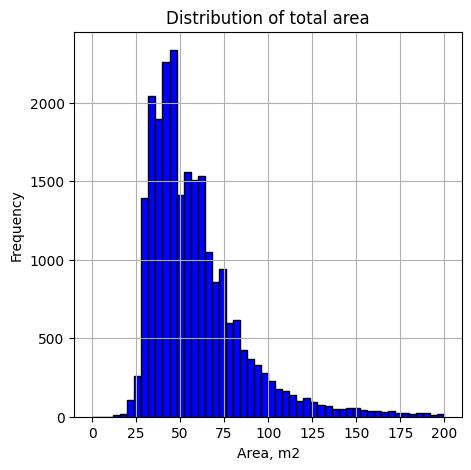

In [260]:
data['total_area'].hist(bins=50, figsize=(5,5),
                        range=(0,200),
                        color='blue',
                        edgecolor='black')
plt.title('Distribution of total area')
plt.xlabel('Area, m2')
plt.ylabel('Frequency')
plt.show()

Проверим самые маленькие и самые большие значения.

In [261]:
data.loc[data['total_area'] > 500][['total_area', 'last_price', 'living_area', 'kitchen_area']]

,total_area,last_price,living_area,kitchen_area
3117,631.0,140000000.0,145.0,60.0
4237,517.0,50000000.0,332.0,22.0
5358,590.0,65000000.0,409.0,100.0
8018,507.0,84000000.0,301.5,45.5
12859,631.2,140000000.0,322.3,19.5
15651,618.0,300000000.0,258.0,70.0
19540,900.0,420000000.0,409.7,112.0


Большие по площади объекты выглядят адекватно.
Возможно, объекты с площадью менее 15 м - комнаты в коммунальных квартирах. Проверим эти значения.

In [262]:
data.loc[data['total_area'] < 15][['total_area', 'last_price', 'living_area', 'kitchen_area']]

,total_area,last_price,living_area,kitchen_area
17961,13.0,1400000.0,17.6,9.0
19546,13.0,1850000.0,17.6,9.0
19558,13.2,1686000.0,17.6,9.0
19642,14.0,1190000.0,11.0,2.0
19807,13.0,3800000.0,10.0,9.0
19904,12.0,2400000.0,10.0,9.0


В некоторых случаях жилая площадь больше, чем общая. Такого быть не должно. Посмотрим на другие объекты с похожей ситуацией.

In [263]:
data.loc[data['total_area'] < data['living_area']][['total_area', 'living_area', 'kitchen_area']]

,total_area,living_area,kitchen_area
1595,62.4,63.600,11.1
3374,41.5,45.000,9.5
8976,41.2,45.000,9.5
9795,42.0,45.000,9.5
9964,49.5,63.600,11.1
11814,42.0,45.000,9.5
11977,62.0,63.600,11.1
12040,15.0,17.600,9.0
12129,30.0,30.500,8.8
12186,71.4,91.785,15.1


Скорее всего, при заполнении значений площади были допущены ошибки. Исключим эти данные.

In [264]:
data = data.loc[data['total_area'] > data['living_area']]

In [265]:
# Проверим, что удаление некоторых объектов ни на что не повлияло.
data['total_area'].describe()

count    23668.000000
mean        60.369177
std         35.663307
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

Общая площадь квартир описывается распределением Пуассона, средняя площадь 60.4 кв.м. за счет очень больших площадей нескольких объектов, медианное значение 52 кв.м. Удалены данные, где жилая площадь превышает общую.

#####  Исследование жилой площади квартир

In [266]:
# Посмотрим на данные в общем.
data['living_area'].describe()

count    23668.000000
mean        34.297840
std         21.677633
min          2.000000
25%         18.400000
50%         30.300000
75%         42.625000
max        409.700000
Name: living_area, dtype: float64

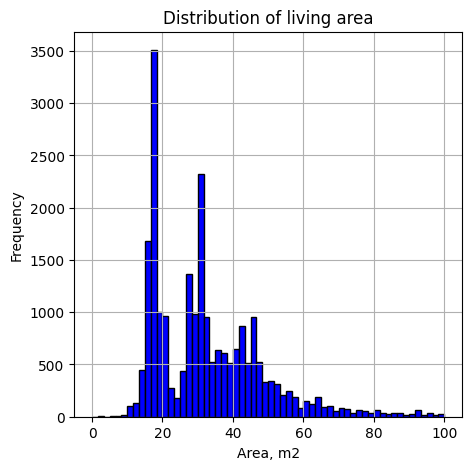

In [267]:
data['living_area'].hist(bins=60,
                         figsize=(5,5),
                         range=(0,100),
                         color='blue',
                         edgecolor='black')
plt.title('Distribution of living area')
plt.xlabel('Area, m2')
plt.ylabel('Frequency')
plt.show()

In [268]:
# Объекты с площадью 2 метра выглядят подозрительно.
data.loc[data['living_area'] < 10][['total_area','ceiling_height', 'last_price', 'living_area', 'kitchen_area']]

,total_area,ceiling_height,last_price,living_area,kitchen_area
114,21.40,2.90,4000000.0,8.3,6.3
680,43.00,NaN,7200000.0,9.0,23.0
1326,52.00,2.70,8100000.0,9.0,32.0
2309,62.40,2.60,4200000.0,8.4,41.0
3242,41.00,NaN,4440000.0,3.0,11.0
4100,34.80,2.70,5300000.0,9.0,17.1
4542,18.00,3.50,3300000.0,9.0,9.0
7312,27.00,2.50,3400000.0,9.0,16.0
8325,52.00,NaN,4800000.0,9.0,6.0
13915,52.00,3.00,6350000.0,2.0,9.0


В некоторых объектах маленькая жилая площадь выглядит как опечатка. Лучше убрать эти данные, их не очень много.

In [269]:
data = data.loc[data['living_area'] > 10]

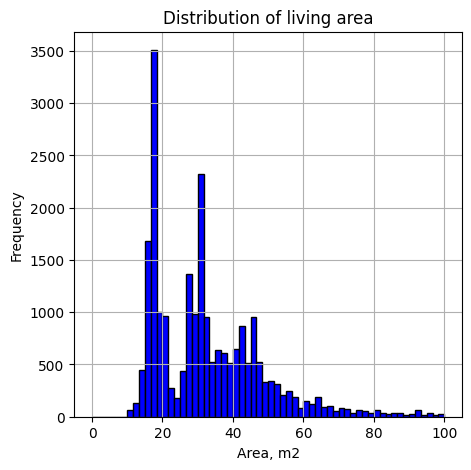

In [270]:
data['living_area'].hist(bins=60,
                         figsize=(5,5),
                         range=(0,100),
                         color='blue',
                         edgecolor='black')
plt.title('Distribution of living area')
plt.xlabel('Area, m2')
plt.ylabel('Frequency')
plt.show()

In [271]:
data['living_area'].describe()

count    23610.000000
mean        34.360372
std         21.667209
min         10.080000
25%         18.500000
50%         30.400000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64

При анализе параметра жилой площади выявлены аномально маленькие значения, часто не характерные для заявленной общей площади. Так как нельзя точно утверждать, что это опечатки, принято решение исключить объекты с жилой площадью менее 10.

После обработки график распределения сгладился, медиана не изменилась, она равна 30.4 кв.м.
Однако по гистаграмме видно, что объекты делятся на две или даже 3 группы - с жилой площадью до 25 м кв. и с площадью 25+ м кв.. Возможно, в меньшую сторону значительно выделяются студии / комнаты в коммуналках.

##### Исследование площади кухни квартир

In [272]:
# Посмотрим на данные в общем.
data['kitchen_area'].describe()

count    23610.000000
mean        10.385347
std          5.696407
min          0.000000
25%          7.200000
50%          9.000000
75%         11.500000
max        112.000000
Name: kitchen_area, dtype: float64

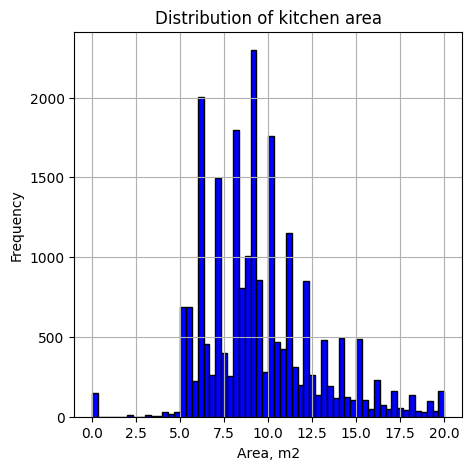

In [273]:
data['kitchen_area'].hist(bins=60,
                          figsize=(5,5),
                          range=(0,20),
                          color='blue',
                          edgecolor='black')
plt.title('Distribution of kitchen area')
plt.xlabel('Area, m2')
plt.ylabel('Frequency')
plt.show()

Скорее всего, отсутствует часть данных с совсем маленькими кухнями. Квартиры без кухонь выглядят странно, но это связано с тем, что при замене пропусков принято, что в квартирах с 0 отдельных комнат (в студиях) будет 0 отдельных кухонь. Скорее всего, кухни либо нет, либо она не выделена в отдельную зону. 

Есть значения, которые встречаются чаще остальных - возможно, это значения из квартир с типовыми планировками (сталинки, хрущевки и т.д.)

##### Исследование высоты потолков

In [274]:
# Проверим столбец высоты потолков на наличие аномалий
data['ceiling_height'].describe()

count    14451.000000
mean         2.771833
std          1.263290
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Можно предположить,что значения > 10 метров (10 ), - это опечатки при вводе дробной части.

Объектами с высотой потолков больше 5 метров могут быть дома, пентхаусы или же маленькие студии с высоким потолком, где разрешено добавить второй уровень (возможно).

Но значение высоты потолка 100 выглядит нереалистично даже при опечатке: 10 для 25-метровой квартиры - высоко, 1 метр - низко.
Потолок 14 метров для площади квартиры 56.4 нереалистичен, как и 1.4 метра. Но можно предположить, что значения даны в футах, тогда при переводе в метры получаются более реалистичные 4.2 метра. Квартира с высотой потолка 10.3 м площадью 45 м2 и стоимостью 5.3 млн тоже не выглядит реалистично (если только высота не в футах).

Подозрительно выглядят также объекты с высотой потолка до 2 метров. Это могут быть нежилые помещения, но площадь и цена похожи на эти параметры для жилых помещений.

Лучше будет убрать эти значения из данных, так как они требуют дополнительной проверки по другим параметрам.
Остальные значения поделим на 10, предполагая, что это опечатка на порядок.

In [275]:
# Посмотрим на слишком большие значения
data.loc[data['ceiling_height'] > 5][['total_area','ceiling_height', 'floor_type', 'last_price']]

,total_area,ceiling_height,floor_type,last_price
355,55.2,25.0,другой,3600000.0
464,280.3,5.2,другой,66571000.0
1026,310.0,5.3,последний,155000000.0
1388,399.0,5.6,последний,59800000.0
3148,75.0,32.0,другой,2900000.0
3474,30.0,8.0,другой,1400000.0
4643,45.0,25.0,другой,4300000.0
4876,25.0,27.0,другой,3000000.0
5076,30.5,24.0,первый,3850000.0
5246,54.0,27.0,другой,2500000.0


In [276]:
# Посмотрим на слишком маленькие значения
data.loc[data['ceiling_height'] < 2][['total_area','ceiling_height', 'floor_type', 'last_price', 'locality_name']]

,total_area,ceiling_height,floor_type,last_price,locality_name
5712,42.8,1.20,первый,1500000.0,мга
16934,40.0,1.75,другой,4100000.0,санкт-петербург
22590,55.0,1.00,другой,6000000.0,санкт-петербург


In [277]:
# Исключаем аномальные значения
data['ceiling_height'] = data.loc[(data['ceiling_height'] != 100) &
                                  (data['ceiling_height'] != 14) &
                                  (data['ceiling_height'] !=10.3) &
                                  (data['ceiling_height'] > 2),
                                 'ceiling_height']
data.loc[data['ceiling_height'] > 5][['total_area','ceiling_height', 'floor_type', 'last_price']]

,total_area,ceiling_height,floor_type,last_price
355,55.2,25.0,другой,3600000.0
464,280.3,5.2,другой,66571000.0
1026,310.0,5.3,последний,155000000.0
1388,399.0,5.6,последний,59800000.0
3148,75.0,32.0,другой,2900000.0
3474,30.0,8.0,другой,1400000.0
4643,45.0,25.0,другой,4300000.0
4876,25.0,27.0,другой,3000000.0
5076,30.5,24.0,первый,3850000.0
5246,54.0,27.0,другой,2500000.0


In [278]:
# Приводим в нужный порядок значения, похожие на опечатку
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height'] / 10

In [279]:
# В данных остались более или менее правидивые значения.
data['ceiling_height'].describe()

count    14434.000000
mean         2.728829
std          0.292151
min          2.000000
25%          2.520000
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

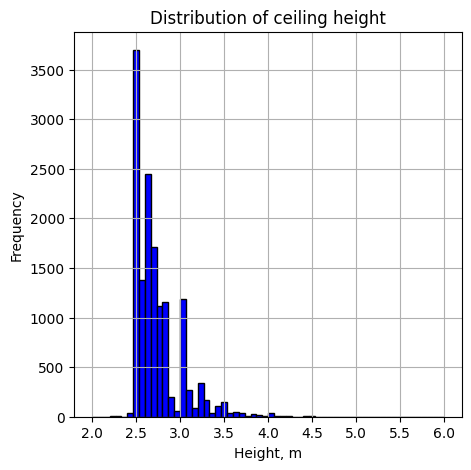

In [280]:
data['ceiling_height'].hist(bins=60,
                            figsize=(5,5),
                            range=(2,6),
                            color='blue',
                            edgecolor='black')
plt.title('Distribution of ceiling height')
plt.xlabel('Height, m')
plt.ylabel('Frequency')
plt.show()

Для высоты потолков убраны аномально высокие и низкие значения. Некоторые значения признаны опечаткой на порядок, исправлены на более правдоподобные. Распределение по форме выглядит как распределение Пуассона, есть выделяющиеся по частоте значения - видимо, типовые для популярных планировок.

##### Исследование цены объекта

In [281]:
# Переведем единицы измерения из рублей в миллионы рублей для удобства восприятия. Посмотрим на данные в общем.
data['last_price'] = data['last_price'] / 1000000
data['last_price'].describe()

count    23610.000000
mean         6.548990
std         10.898945
min          0.012190
25%          3.426000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

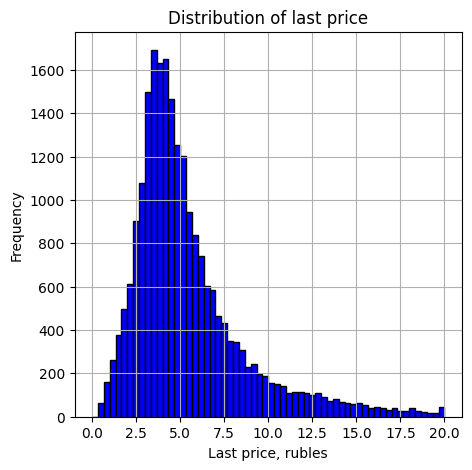

In [282]:
data['last_price'].hist(bins=60,
                        figsize=(5,5),
                        range=(0,20),
                        color='blue',
                        edgecolor='black')
plt.title('Distribution of last price')
plt.xlabel('Last price, rubles')
plt.ylabel('Frequency')
plt.show()

In [283]:
# Цена квартиры 12 тыс. рублей выглядит подозрительно. Посмотрим на нее внимательнее.
data.loc[data['last_price'] < 0.5][['total_area', 'last_price', 'price_per_meter', 'locality_name']]

,total_area,last_price,price_per_meter,locality_name
5698,42.0,0.45000,10714.29,будогощь
6859,40.0,0.49000,12250.00,старополье
8793,109.0,0.01219,111.83,санкт-петербург
9581,43.4,0.45000,10368.66,старополье
10782,29.1,0.49000,16838.49,сланцы
14911,54.0,0.43000,7962.96,свирь
16032,32.0,0.48000,15000.00,сланцы
16219,38.5,0.45000,11688.31,вахнова кара
16274,40.0,0.44000,11000.00,старополье
17456,30.4,0.43000,14144.74,сланцы


In [284]:
# Исключим это значение, 111 рублей за кв.м в Санкт-Петербурге выглядит неправдоподобно.
data = data.loc[data['last_price'] > 0.1]

In [285]:
data['last_price'].describe()

count    23609.000000
mean         6.549267
std         10.899093
min          0.430000
25%          3.429000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

В среднем, стоимость квартиры равна 5.2 млн.рублей, однако есть очень дорогие объекты с ценой 763 млн.рублей, они завышают математическое ожидание (7.48 млн.руб.).

##### Исследование параметра количество комнат

In [286]:
# Посмотрим на количество комнат в общем.
data['rooms'].describe()

count    23609.000000
mean         2.073997
std          1.073260
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

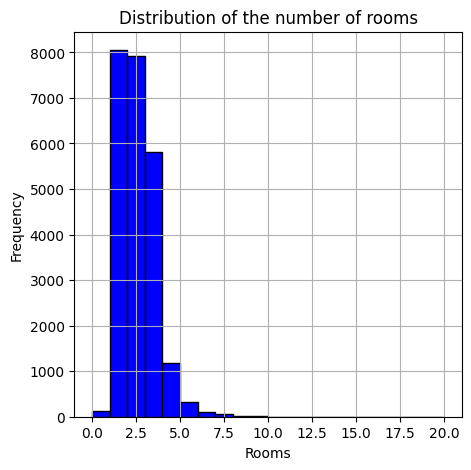

In [287]:
data['rooms'].hist(bins=20,
                   figsize=(5,5),
                   range=(0,20),
                   color='blue',
                   edgecolor='black')
plt.title('Distribution of the number of rooms')
plt.xlabel('Rooms')
plt.ylabel('Frequency')
plt.show()

In [288]:
# Проверим, означает ли 0 комнат, что квартира - студия.
if data.loc[data['rooms'] == 0]['studio'].sum() == len(data.loc[data['rooms'] == 0]):
    print('Квартиры с 0 комнат - это студии')

Квартиры с 0 комнат - это студии


In [289]:
# Проверим, коррелируется количество комнат с площадью квартир.
data['rooms'].corr(data['total_area'])

0.7601137846217222

Большинство продающихся квартир состоит из 2 комнат. Квартиры с 0 комнат - студии. Максимум - 19 комнат.
Количество комнат прямо связано с площадью квартир.

##### Исследование параметра тип этажа квартиры («первый», «последний», «другой»)

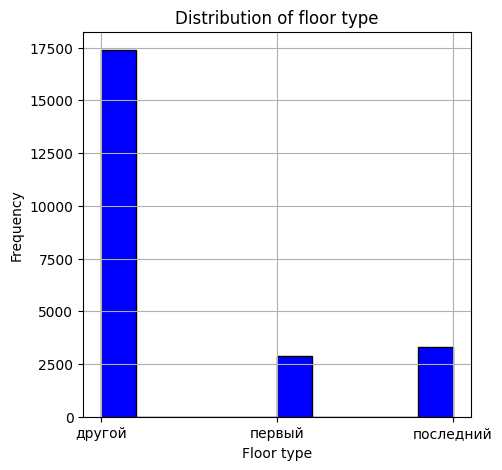

In [290]:
data['floor_type'].hist(figsize=(5,5),
                        color='blue',
                        edgecolor='black')
plt.title('Distribution of floor type')
plt.xlabel('Floor type')
plt.ylabel('Frequency')
plt.show()

Очевидно, что квартир не на первом и не на последнем этаже в разы больше. Квартиры на первых этажах пользуются меньшим спросом.

##### Исследование параметра общее количество этажей в доме;


In [291]:
data['floors_total'].describe()

count    23525.000000
mean        10.674772
std          6.594733
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

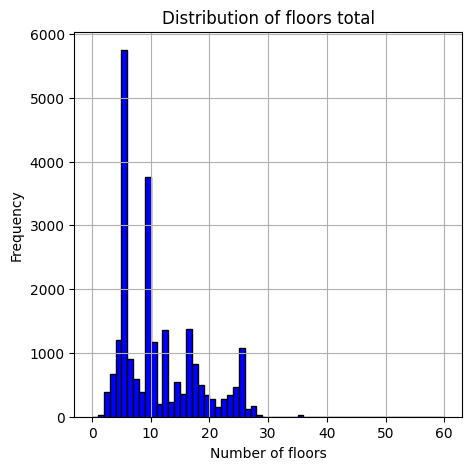

In [292]:
data['floors_total'].hist(bins=60,
                          figsize=(5,5),
                          range=(0,60),
                          color='blue',
                          edgecolor='black')
plt.title('Distribution of floors total')
plt.xlabel('Number of floors')
plt.ylabel('Frequency')
plt.show()

In [293]:
data.loc[data['floors_total'] > 30][['floors_total', 'floor_type', 'locality_name', 'last_price', 'cityCenters_nearest']]

,floors_total,floor_type,locality_name,last_price,cityCenters_nearest
397,36.0,другой,санкт-петербург,5.990000,20444.0
871,35.0,другой,санкт-петербург,7.777777,20444.0
1060,35.0,другой,санкт-петербург,5.200000,20444.0
1697,34.0,другой,санкт-петербург,3.550000,20444.0
1917,35.0,другой,санкт-петербург,10.150000,20444.0
2253,60.0,другой,кронштадт,3.800000,49488.0
2966,35.0,другой,санкт-петербург,4.300000,20444.0
4855,35.0,другой,санкт-петербург,5.500000,20339.0
5749,35.0,другой,санкт-петербург,3.590000,20444.0
5807,36.0,другой,санкт-петербург,8.150000,20444.0


In [294]:
data = data[data['floors_total'] != 60]

Уберем из выборки 60-этажное здание в Кронштадте (т.к. в Кронштадте все здания до 14 этажей), скорее всего, это опечатка (6 этажей). Также не совсем понятно, в каком здании в Санкт-Петербурге 52 этажа - в здании Лидер Тауэр 42 этажа, но эта информация ни на что особо не повлияет. Объекты с 35-37 этажей это один и тот же жилой комплекс с разным учетом этажности подземного паркинга.

По гистограмме видно самые популярные форматы этажности: 5, 9 этажей.

##### Исследование параметра расстояние до центра города в метрах

In [295]:
data['cityCenters_nearest'].describe()

count    18799.000000
mean     14457.379807
std       8597.313979
min        181.000000
25%       9487.000000
50%      13266.000000
75%      16763.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

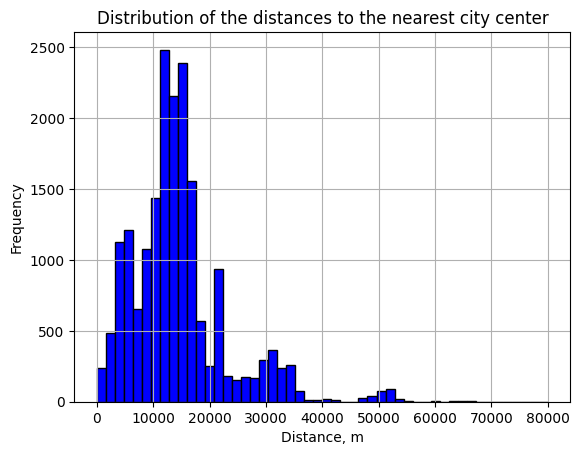

In [296]:
data['cityCenters_nearest'].hist(bins=50,
                                 range=(0, 80000),
                                 color='blue',
                                 edgecolor='black')
plt.title('Distribution of the distances to the nearest city center')
plt.xlabel('Distance, m')
plt.ylabel('Frequency')
plt.show()

In [297]:
# Посмотрим на группу населенных пунктов с максимальным расстоянием до центра Санкт-Петербурга
(data[data['cityCenters_nearest'] > 45000][['cityCenters_nearest','locality_name']]
 .groupby('locality_name')['cityCenters_nearest'].median()).sort_values()

locality_name
репино         45226.0
петергоф       48914.5
кронштадт      49575.0
ломоносов      51753.5
зеленогорск    53381.0
молодёжное     65764.0
Name: cityCenters_nearest, dtype: float64

In [298]:
# Посмотрим на самые близкие к центру объекты
(data[data['cityCenters_nearest'] < 15000][['cityCenters_nearest','locality_name']]
 .groupby('locality_name')['cityCenters_nearest'].count()).sort_values()

locality_name
нет названия          36
санкт-петербург    11846
Name: cityCenters_nearest, dtype: int64

In [299]:
# Посмотрим на пик около 21 км от центра.
(data[(data['cityCenters_nearest'] > 20000) & (data['cityCenters_nearest'] < 23000)][['cityCenters_nearest','locality_name']]
 .groupby('locality_name')['cityCenters_nearest'].count()).sort_values()

locality_name
шушары               1
стрельна             9
парголово           71
санкт-петербург    418
мурино             585
Name: cityCenters_nearest, dtype: int64

Так как самый малый диаметр Санкт-Петербурга составляет 32 км, объекты без названия населенного пункта (НП) можно определить к Санкт-Петербургу.

In [300]:
data.loc[(data['cityCenters_nearest'] < 15000) & (data['locality_name'] == 'нет названия'), 'locality_name'] = 'санкт-петербург'

По гистаграмме видно, что данные неоднородны, и для описания распределения необходимо разделить выборки - например, по объектам, находящимся в Санкт-Петербурге (можно выделить группу до 10 км - центр, от 10 до 25 км - не центр СПб) и по объектам, находящимся в Ленинградской области и ближайших пригородах (спальных районах).

На расстоянии 21 км от центра Санкт-Петербурга очень много объектов - что похоже на правду, так как Мурино особенно активно развивается.

Максимальное удаление от центра у НП Молодежное.

##### Исследование параметра расстояния до ближайшего парка.

In [301]:
data['parks_nearest'].describe()

count    8040.000000
mean      490.790423
std       342.272306
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

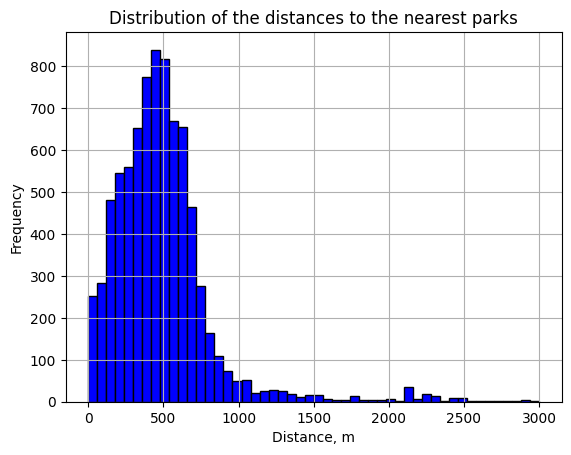

In [302]:
data['parks_nearest'].hist(bins=50,
                           range=(0, 3000),
                           color='blue',
                           edgecolor='black')
plt.title('Distribution of the distances to the nearest parks')
plt.xlabel('Distance, m')
plt.ylabel('Frequency')
plt.show()

In [303]:
#### Посмотрим на объекты, близкие к паркам. 
data.loc[data['parks_nearest'] < 5][['parks_nearest', 'floors_total', 'locality_name', 'last_price', 'cityCenters_nearest']]

,parks_nearest,floors_total,locality_name,last_price,cityCenters_nearest
11949,3.0,9.0,санкт-петербург,4.500,12292.0
14624,1.0,9.0,санкт-петербург,3.770,16436.0
22941,4.0,4.0,зеленогорск,10.965,54490.0


Чаще всего встречаются объекты, для которых ближайший парк находится в 455 м - 500 м.
Существует даже объект с расстоянием до парка в 1 м. Такие близкие к паркам объекты не выбиваются из распределения, поэтому с расстояниями должно быть все хорошо.

***Выводы:***
- Чаще всего продаются квартиры с площадью 52 кв. м;
- Из данных исключены объекты с жилой площадью, превышающей общую, а также слишком маленькие значения жилой площади по отношению к общей;
- Для кухонь, потолков и общей этажности выделяются некоторые популярные значения, которые приняты при типовой застройке;
- Для высоты потолков убраны аномально высокие и низкие значения. Некоторые значения признаны опечаткой на порядок, исправлены на более правдоподобные;
- Чаще всего продают 2-комнатные квартиры;
- Исключены аномально высокие значения этажности для пригородов Санкт-Петербурга;
- Некоторые объекты без названия населенного пункта находятся в пределах Санкт-Петербурга, поэтому определены как Санкт-Петербург;

#### Факторы влияния на общую (полную) стоимость объекта
<a id='matrix'></a>

Scatter plot for the most important parameters


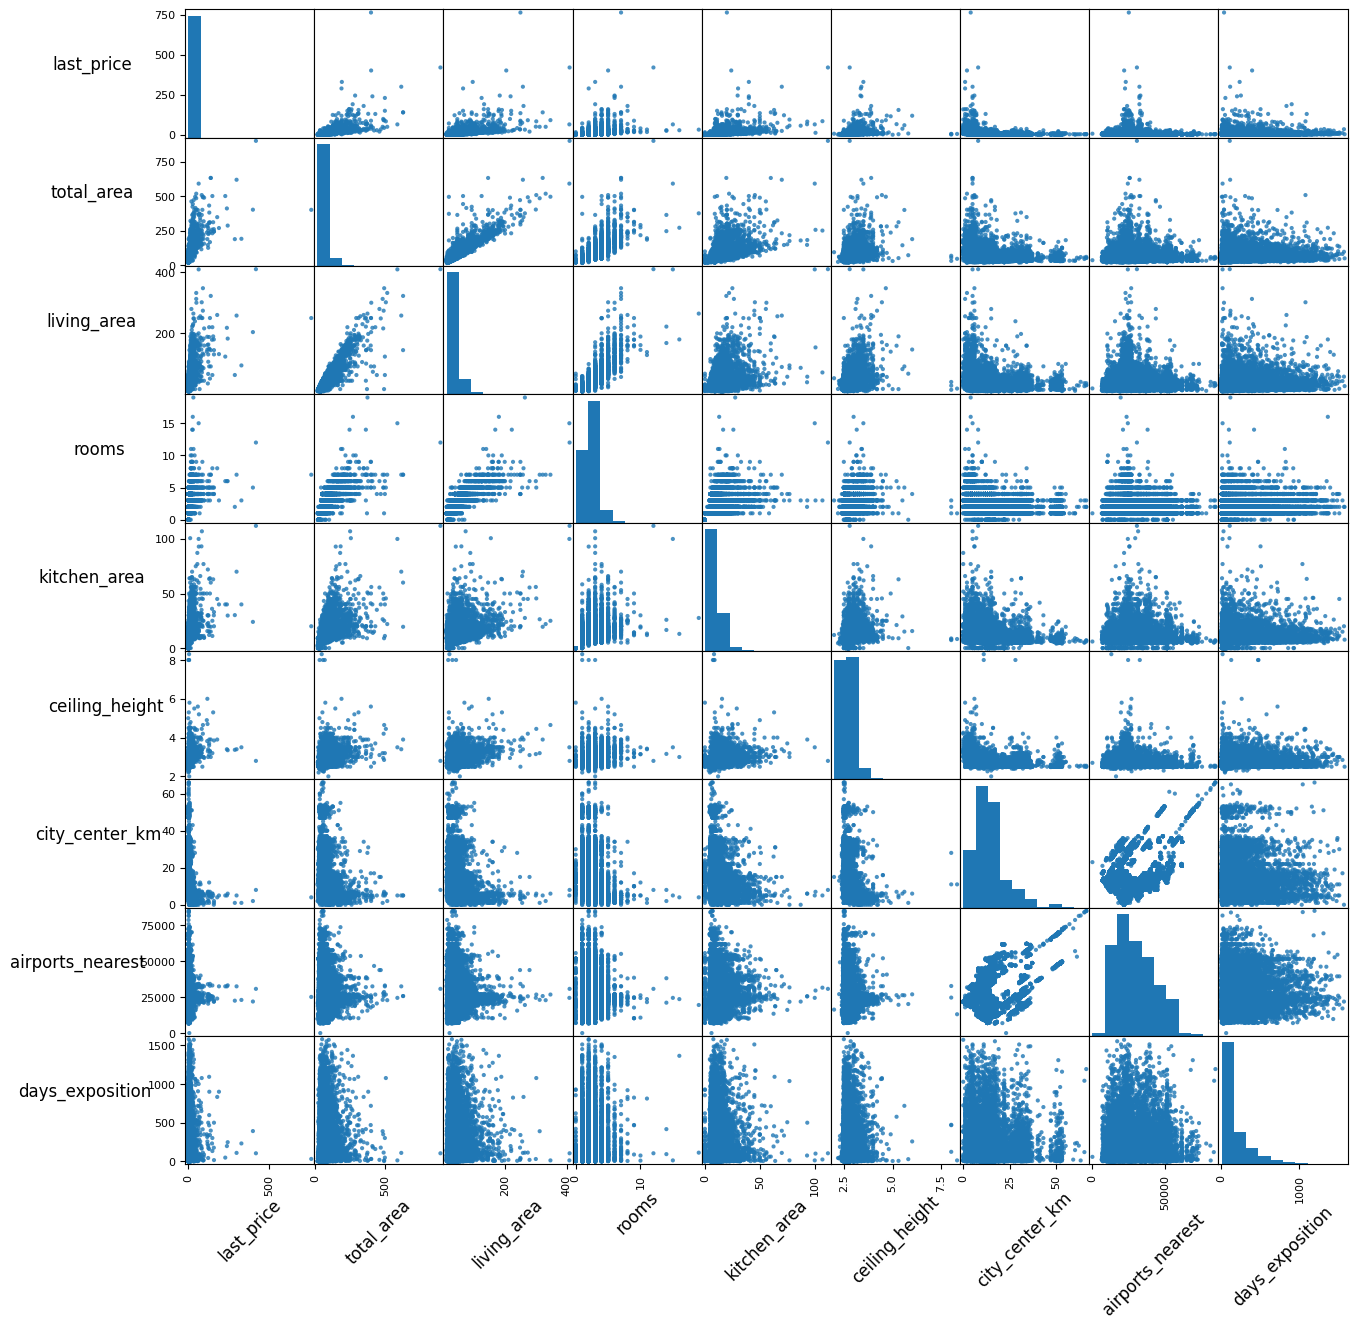

In [304]:
# Отфильтруем данные, оставив только численные значения
numeric_data = data.select_dtypes(include=[np.number])
# Отфильтруем самые нужные параметры
useful_columns = ['last_price', 'total_area', 'living_area','rooms', 'kitchen_area',
                  'ceiling_height', 'city_center_km', 'airports_nearest', 'days_exposition']
# Построим попарные диаграммы рассеяния 
scatter_matrix_fig = pd.plotting.scatter_matrix(numeric_data[useful_columns], figsize=(15, 15), alpha=0.8)
for ax in scatter_matrix_fig.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12, rotation=45, labelpad=0)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12, rotation=0, labelpad=45)
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
print('Scatter plot for the most important parameters')

In [305]:
# Построим матрицу коэффициентов корреляции
pd.set_option('display.max_columns', None)
numeric_data[useful_columns].corr()

,last_price,total_area,living_area,rooms,kitchen_area,ceiling_height,city_center_km,airports_nearest,days_exposition
last_price,1.000000,0.653774,0.558006,0.364740,0.454015,0.379664,-0.213046,-0.043489,0.080995
total_area,0.653774,1.000000,0.911231,0.760115,0.591068,0.458932,-0.240612,-0.056140,0.149757
living_area,0.558006,0.911231,1.000000,0.853736,0.429515,0.427375,-0.236859,-0.082800,0.141917
rooms,0.364740,0.760115,0.853736,1.000000,0.291787,0.282872,-0.198057,-0.091383,0.127308
kitchen_area,0.454015,0.591068,0.429515,0.291787,1.000000,0.381059,-0.182667,0.003726,0.105673
ceiling_height,0.379664,0.458932,0.427375,0.282872,0.381059,1.000000,-0.351056,-0.106879,0.125205
city_center_km,-0.213046,-0.240612,-0.236859,-0.198057,-0.182667,-0.351056,1.000000,0.308407,-0.064745
airports_nearest,-0.043489,-0.056140,-0.082800,-0.091383,0.003726,-0.106879,0.308407,1.000000,-0.026525
days_exposition,0.080995,0.149757,0.141917,0.127308,0.105673,0.125205,-0.064745,-0.026525,1.000000


Correlation matrix heatmap


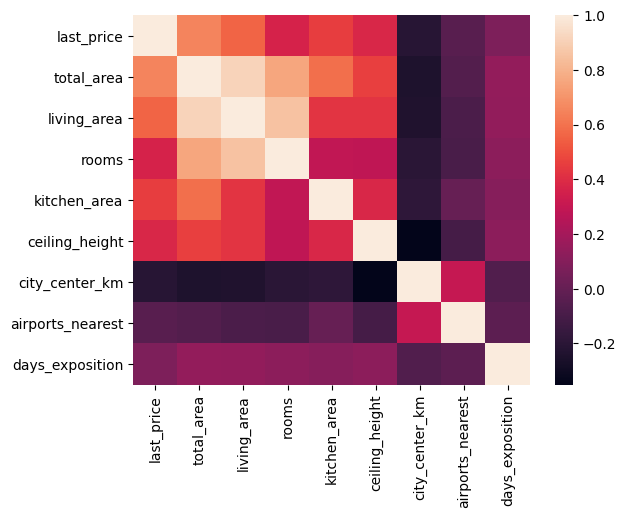

In [306]:
sns.heatmap(numeric_data[useful_columns].corr())
print('Correlation matrix heatmap')
plt.show()

Визуально достаточно сложно ориентироваться во всех получившихся диаграммах рассеяния, поэтому оставим самые важные параметры и визуализируем матрицу коэффициентов корреляции. Очевидны следующие прямые зависимости:
- Из "неожиданного": чем больше общая площадь, жилая и пл.кухни, тем больше цена (к. корреляции 0.65, 0.55, 0.45 соответственно), чем больше площадь, тем больше комнат (0.76), а также жилой (0.85) и кухонной площадей (0.59), чем больше комнат, тем больше конечная стоимость объекта (0.36);
- Чем больше площадь квартир, тем потолки выше (0.46);
- Чем ближе к центру, тем потолки выше (-0.35, но ведь увеличение расстояния это удаленность от центра, поэтому связь с приближением прямая);
- Также есть некоторая прямая связь между площадью и высотой потолков (0.46);
- Есть связь между расстояниями до аэропорта и до центра города, выделяется несколько групп точек, связь возникает из-за того, что в пространстве действительно есть связи между точками.


Скорее всего, лучше искать нелинейные зависимости между этими параметрами, так как коэффициенты корреляции достаточно низкие.

#### Как быстро продавались квартиры?
<a id='timeline'></a>

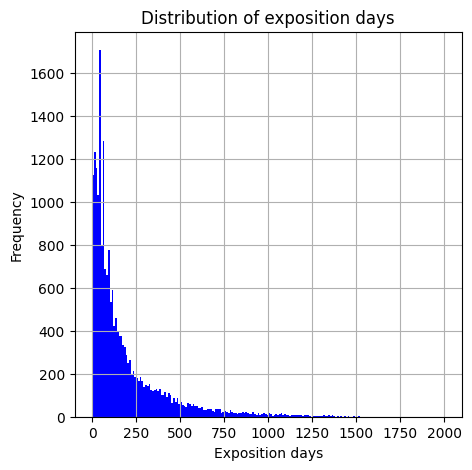

In [307]:
# Визуально оценим параметр дней показа объявлений.
data['days_exposition'].hist(bins=200,
                             figsize=(5,5),
                             range=(0,2000),
                             color='blue',)
plt.title('Distribution of exposition days')
plt.xlabel('Exposition days')
plt.ylabel('Frequency')
plt.show()

In [308]:
data['days_exposition'].describe()

count    20434.000000
mean       181.076833
std        219.931097
min          1.000000
25%         45.000000
50%         95.500000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Обычно продажа занимает примерно 105 дней, но есть необычно быстрые сделки (от 1 дня) и очень долго непродающиеся объекты (больше года и даже нескольких лет), которые сильно увеличивают математическое ожидание (до 195 дней). Распределение данных экспоненциальное. Большинство квартир продается до полугода. Также видно пик встречаемости до 100 дней - возможно, это бесплатный период публикации объявлений. 

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
<a id='popular'></a>

In [309]:
# Посмотрим на параметр в общем, для удобства выразим в тысячах рублей
(data['price_per_meter'] / 1000).describe()

count    23608.000000
mean        99.379509
std         50.273926
min          7.962960
25%         76.565223
50%         95.000000
75%        114.166162
max       1907.500000
Name: price_per_meter, dtype: float64

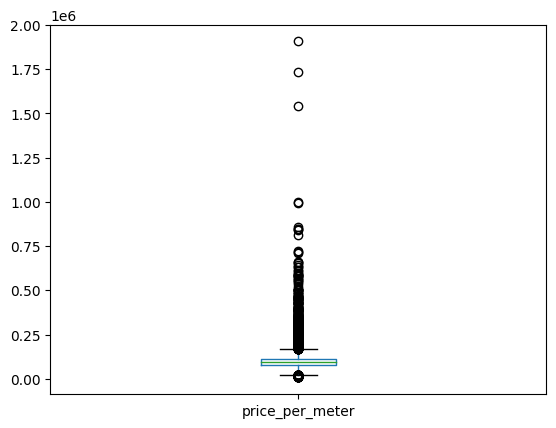

In [310]:
# Стоимость квадратного метра имеет очень большой разброс - много высоких значений, поэтому будем использовать медиану.
data['price_per_meter'].plot.box()
plt.show()

In [311]:
# Оценим НП с самой низкой стоимостью квадратного метра.
data.loc[data['price_per_meter'] < 100000][['price_per_meter', 'total_area','locality_name']].sort_values(by='price_per_meter').head(10)

,price_per_meter,total_area,locality_name
14911,7962.96,54.0,свирь
4405,9615.38,52.0,сланцы
11351,10185.19,54.0,сланцы
9581,10368.66,43.4,старополье
23477,10507.25,138.0,гатчина
23484,10561.80,44.5,сланцы
5698,10714.29,42.0,будогощь
19460,10769.23,52.0,сланцы
9471,10897.44,78.0,гатчина
15969,10925.93,54.0,сланцы


In [312]:
# Создадим датафрейм по топу локаций по количеству предложений, затем посчитаем медианную стоимость 1 кв.м для этого НП
top_localities = data['locality_name'].value_counts().nlargest(10).index.tolist()
filtered_data = data[data['locality_name'].isin(top_localities)]
mean_price_per_meter = filtered_data.groupby('locality_name')['price_per_meter'].median().reindex(top_localities).reset_index()
mean_price_per_meter.columns = ['locality_name', 'average_price_per_meter']
mean_price_per_meter

,locality_name,average_price_per_meter
0,санкт-петербург,104694.175
1,мурино,86111.110
2,кудрово,95762.710
3,шушары,76923.080
4,всеволожск,65789.470
5,пушкин,99993.590
6,колпино,74723.745
7,парголово,91642.860
8,гатчина,67796.610
9,выборг,58133.215


Самые популярные населенные пункты: Санкт-Петербург, Пушкин, Петергоф. В Зеленогорске, Санкт-Петербурге и Пушкине самый дорогой квадратный метр.

#### Определение факторов, которые больше всего влияют на общую (полную) стоимость объекта». 
       
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - количество комнат;
  - тип этажа, на котором расположена квартира (первый, последний, другой);
  - дата размещения (день недели, месяц, год).

Для оценки связи воспользуемся графиками линейной регрессии, так как они наиболее наглядно демонстрируют отсутствие или наличие связи.
<a id='price_factors'></a>

##### Общая площадь

Function of last price and total area


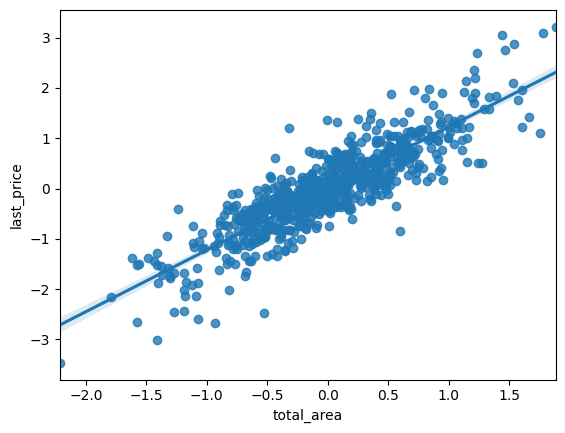

In [313]:
# Вычисление логарифмических разностей для построения графика линейной регрессии, 
# который будет полезен в оценке зависимости цены от других факторов. Замена 0, так как логарифм 0 не определен, на отсутствующие знаечния.

trans_data = np.log(numeric_data).replace([np.inf, -np.inf], np.nan).dropna().diff().dropna()
sns.regplot(x='total_area', y='last_price', data=trans_data)
print('Function of last price and total area')
plt.show()

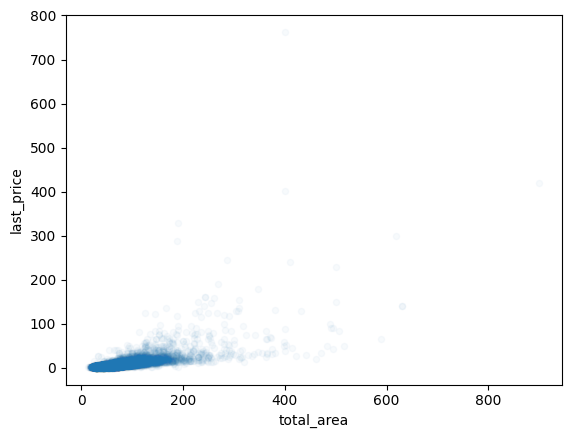

In [314]:
# Сравним наглядность методов поиска взаимосвязи: диаграмма рассеяния дает представление о слабой прямой связи, но менее наглядно
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.03) 
plt.show()

In [315]:
# Коэффициент корреляции между конечной стоимостью объекта и общей площадью
data['last_price'].corr(data['total_area'])

0.6537736863459932

Существует прямая линейная связь между стоимостью объекта и его общей площадью с коэффициентом корреляции 0.60.

##### Жилая площадь

Function of last price and living area


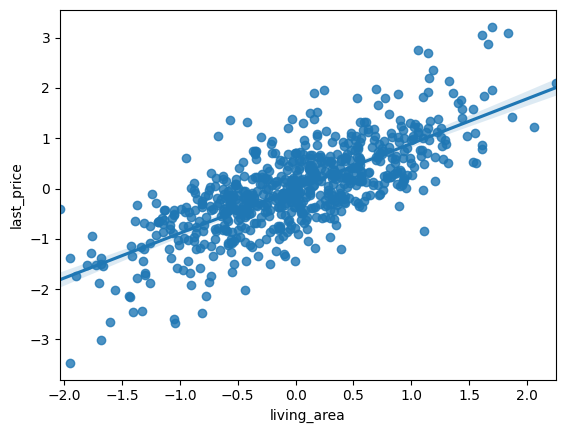

In [316]:
sns.regplot(x='living_area', y='last_price', data=trans_data)
print('Function of last price and living area')
plt.show()

In [317]:
data['last_price'].corr(data['living_area'])

0.5580059064204578

Существует прямая линейная связь между стоимостью объекта и его жилой площадью с коэффициентом корреляции 0.53.

##### Площадь кухни

Function of last price and kitchen area


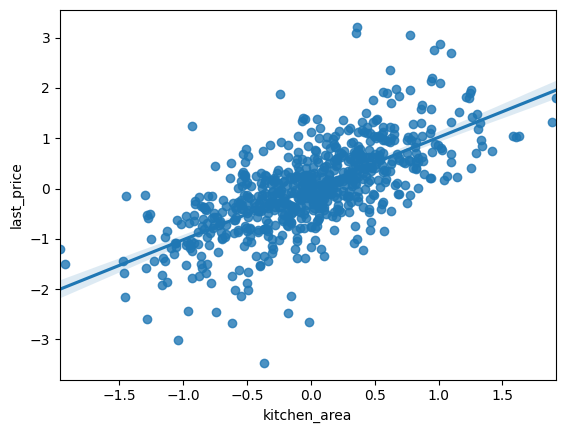

In [318]:
sns.regplot(x='kitchen_area', y='last_price', data=trans_data)
print('Function of last price and kitchen area')
plt.show()

In [319]:
data['last_price'].corr(data['kitchen_area'])

0.4540149183492646

Существует слабая прямая линейная связь между стоимостью объекта и его общей площадью с коэффициентом корреляции 0.41.

##### Количество комнат

Function of last price and the number of rooms


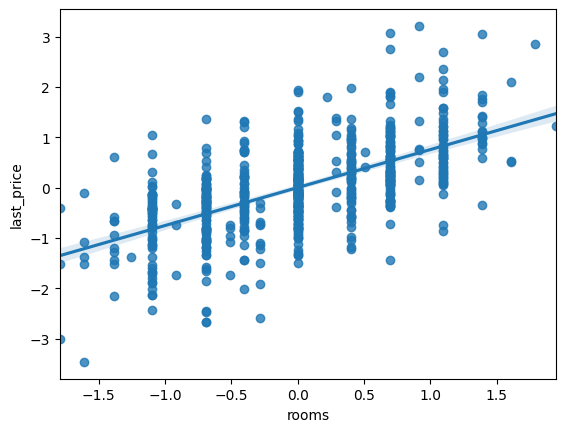

In [320]:
sns.regplot(x='rooms', y='last_price', data=trans_data)
print('Function of last price and the number of rooms')
plt.show()

In [321]:
data['last_price'].corr(data['rooms'])

0.36473964339944775

Существует слабая прямая линейная связь между стоимостью объекта и количеством комнат (так как площадь тоже связана с количеством комнат) с коэффициентом корреляции 0.37.

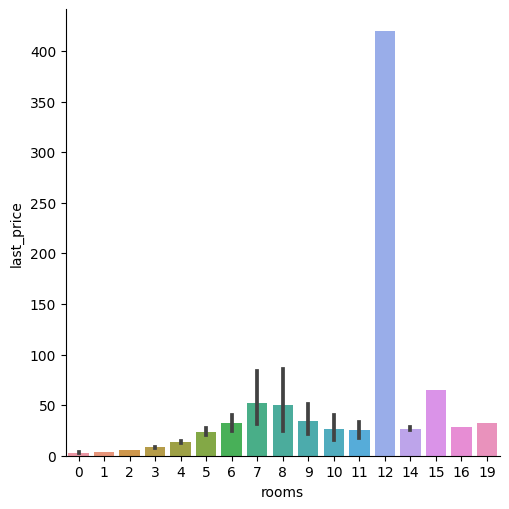

In [322]:
# Попробуем визуализировать категориальные переменные - комнаты, таким образом:
sns.catplot(x='rooms', y='last_price', kind='bar', data=data)
plt.show()

Квартиры с 15 комнатами очень дорогие, возможно, есть другие факторы, так сильно влияющие на стоимость именно этих 15-ти комнатных квартир. В данных много выбивающихся значений, но, в любом случае, существующая зависимость не очень хорошо описывается линейно.

In [323]:
# Посмотрим коэффициент корреляции
data['last_price'].corr(data['rooms'])

0.36473964339944775

Самая сильная связь у недорогих квартир, распределение стоимости в зависимости от количества комнат меняет характер зависимостей у более дорогих квартир (либо же данных не хватает для выделения закономерностей, но вряд ли они линейные). Общий коэффициент корреляции всего 0.36, слабая прямая зависимость.

##### Тип этажа, на котором расположена квартира

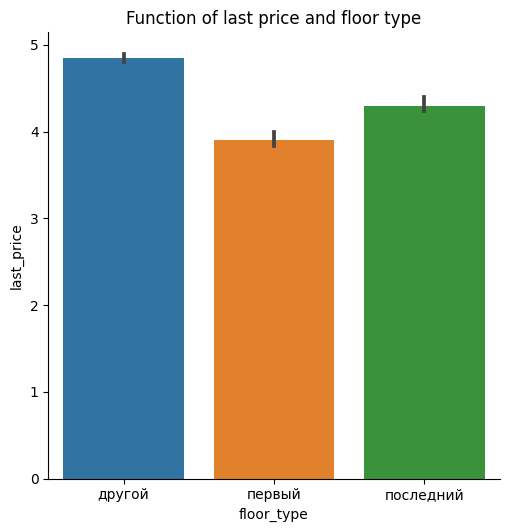

In [324]:
sns.catplot(x='floor_type', y='last_price', kind='bar', estimator=np.median, data=data)
plt.title('Function of last price and floor type')
plt.show()

Квартиры на первом этаже в целом чаще дешевле, чем на других этажах. Самое высокое значение цены на последнем этаже (пентхаусы дороже обычных квартир).

##### День публикации объявления

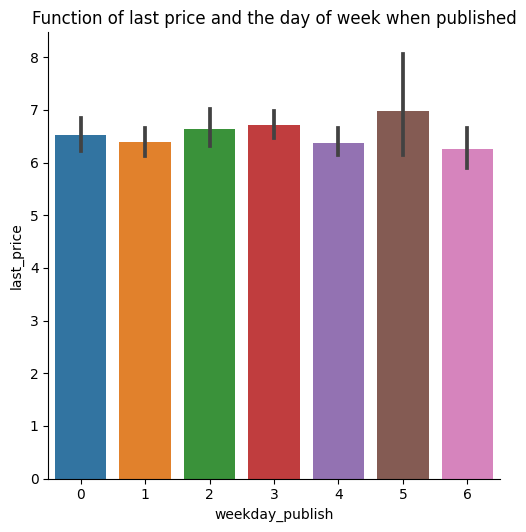

In [325]:
# 0 - понедельник, 6 - воскресенье
sns.catplot(x='weekday_publish', y='last_price', kind='bar', data=data)
plt.title('Function of last price and the day of week when published')
plt.show()

Более "дорогие" объявления публикуются в субботу, воскресенье - день с публикацией относительно недорогих вариантов.

##### Месяц публикации объявления

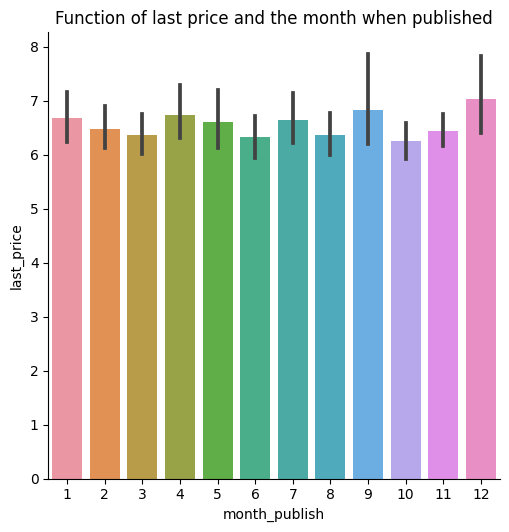

In [326]:
sns.catplot(x='month_publish', y='last_price', kind='bar', data=data)
plt.title('Function of last price and the month when published')
plt.show()

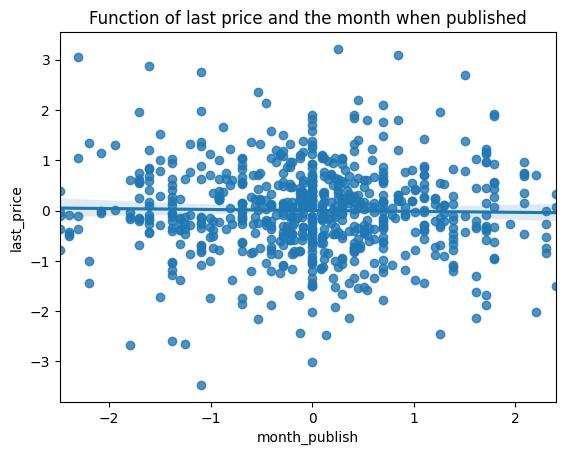

In [327]:
# График линейной регрессии
sns.regplot(x='month_publish', y='last_price', data=trans_data)
plt.title('Function of last price and the month when published')
plt.show()

Более дорогие варианты квартир выставляют в сентябре, а в октябре - самые недорогие. По графику линейной регрессии видно, что линейной связи нет.

##### Год публикации объявления

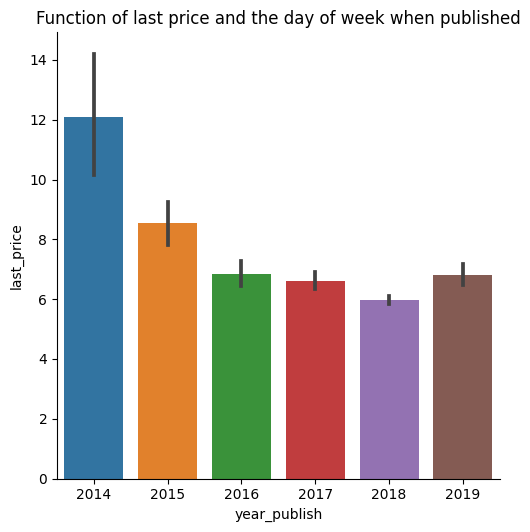

In [328]:
sns.catplot(x='year_publish', y='last_price', kind='bar', data=data)
plt.title('Function of last price and the day of week when published')
plt.show()

В целом, по 2017 и 2018 годам больше данных, но есть тенденция к уменьшению стоимости публикуемых квартир с годами.

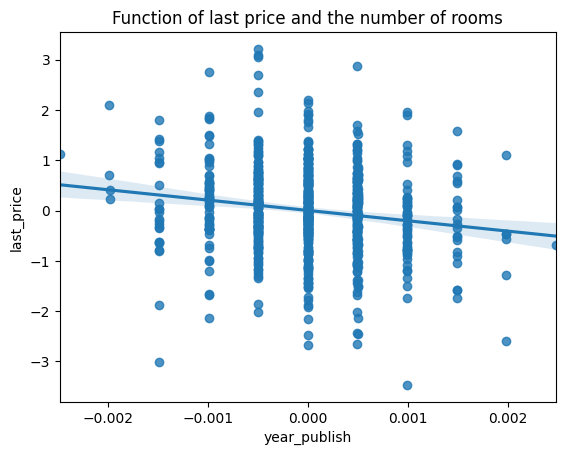

In [329]:
sns.regplot(x='year_publish', y='last_price', data=trans_data)
plt.title('Function of last price and the number of rooms')
plt.show()

***Выводы:***
С помощью различных типов графиков, позволяющих оценить взаимосвязь двух параметров, выявлены линейные зависимости, в некоторых случаях выявлено отсутствие прямой связи.
- Существует прямая линейная связь между стоимостью объекта и его общей площадью с коэффициентом корреляции 0.6;
- Существует прямая линейная связь между стоимостью объекта и его жилой площадью с коэффициентом корреляции 0.53;
- Существует слабая прямая линейная связь между стоимостью объекта и его общей площадью с коэффициентом корреляции 0.41;
- Квартиры с 12 комнатами очень дорогие, возможно, есть другие факторы, так сильно влияющие на стоимость именно этих 12-ти комнатных квартир. Существующая зависимость не очень хорошо описывается линейно;
- Самая сильная связь у недорогих квартир, распределение стоимости в зависимости от количества комнат меняет характер зависимости у более дорогих квартир (либо же данных не хватает для выделения закономерностей, но вряд ли они линейные). Общий коэффициент корреляции всего 0.37, слабая прямая зависимость;
- Квартиры на первом этаже в целом чаще дешевле, чем на других этажах. Самое высокое значение цены на последнем этаже;
- Более "дорогие" объявления публикуются в субботу, относительно недорогие варианты публикуют в воскресенье;
- Более дорогие варианты квартир выставляют в сентябре, а в октябре - самые недорогие. По графику линейной регрессии видно, что линейной связи нет.
- В целом, по 2017 и 2018 годам больше данных, но есть тенденция к уменьшению стоимости публикуемых квартир с годами.

#### Средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра
<a id='spb_average'></a>

In [330]:
# Сгруппируем медианную стоимость квартир по каждому километру удаления от центра
average_price = data.groupby('city_center_km')['last_price'].median().reset_index()
average_price.columns = ['city_center_km', 'average_price']
sorted_price = average_price.sort_values(by='city_center_km')

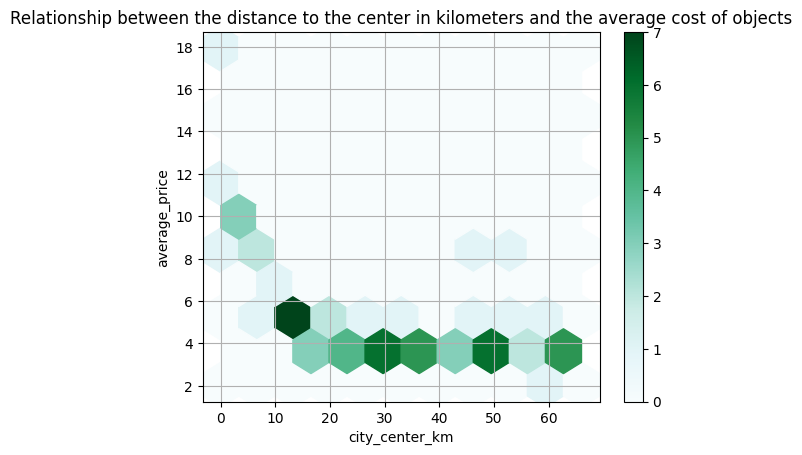

In [331]:
# Посмотрим на связь между расстоянием до центра в километрах и средней стоимостью объектов
sorted_price.plot(x='city_center_km',
                  y='average_price',
                  kind='hexbin',
                  gridsize=10,
                  sharex=False,
                  grid=True)
plt.title('Relationship between the distance to the center in kilometers and the average cost of objects')
plt.show()

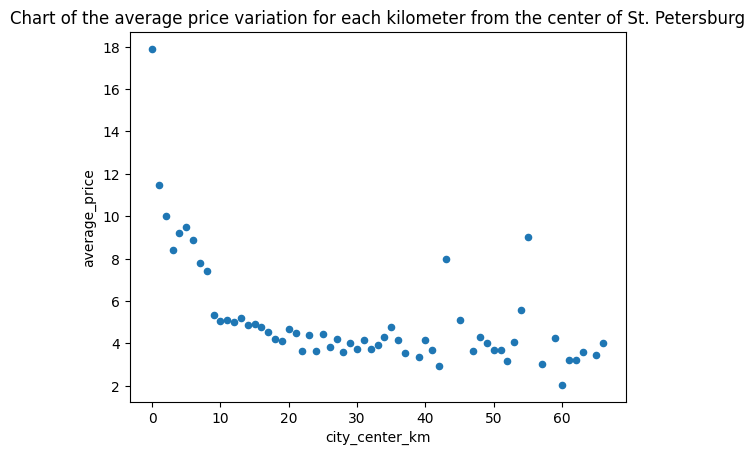

In [332]:
sorted_price.plot(x='city_center_km',
                  y='average_price',
                  kind='scatter',
                  title='Chart of the average price variation for each kilometer from the center of St. Petersburg')
plt.show()

Связь между стоимостью квартир и отдалением от центра Санкт-Петербурга выглядит обратно пропорциональной и нелинейной.

Получается, что при с приближением к центру города стоимость квартир нелинейно растет, причем чем ближе к центру (расстояние до 10 км), тем быстрее этот рост.

### Общий вывод

***В результате предобработки данных:***
- Устранены пропуски в столбцах living_area, is_apartment, kitchen_area, balcony, locality_name, parks_around3000, ponds_around3000, airports_nearest, cityCenter_nearest. В столбцах высоты потолков, общего количества этажей, расстояний до ближайшего парка и пруда, днях показа объявления пропуски оставлены, так как нет возможности установить значения для заполнения.
- Устранены дубликаты в столбце locality_name. Для анализа оставлен 301 населенный пункт + все населенные пункты с пропущенными значениями названия заменены на "нет названия". 
- Изменен тип данных столбцов is_apartment с object на boolean, так как значения принимали два строковых значения "False/True".  В first_day_exposition изменен тип данных с object на datetime для дальнейшей обработки.
- Аномалии решено обрабатывать на этапе изучения переменных.
[Подробнее](#data_processing)

***В таблицу добавлены параметры:***
- цена одного квадратного метра - price_per_meter;
- день публикации объявления (0 - понедельник, 1 - вторник и т. д.) - weekday_publish;
- месяц публикации объявления - month_publish;
- год публикации объявления - year_publish;
- тип этажа квартиры (значения — «первый», «последний», «другой») - floor_type;
- расстояние до центра города в километрах - city_center_km.
[Подробнее](#parameters)

***Изучены и описаны параметры, которые могут иметь влияние на стоимость недвижимости:***
- Чаще всего продаются квартиры с площадью 52 кв. м;
- Из данных исключены объекты с жилой площадью, превышающей общую, а также слишком маленькие значения жилой площади по отношению к общей;
- Для кухонь, потолков и общей этажности выделяются некоторые популярные значения, которые приняты при типовой застройке;
- Для высоты потолков убраны аномально высокие и низкие значения. Некоторые значения признаны опечаткой на порядок, исправлены на более правдоподобные;
- Чаще всего продают 2-комнатные квартиры;
- Исключены аномально высокие значения этажности для пригородов Санкт-Петербурга;
- Некоторые объекты без названия населенного пункта находятся в пределах Санкт-Петербурга, поэтому определены как Санкт-Петербург;
[Подробнее](#data)

***Изучение взаимосвязей параметров:***
Очевидны следующие прямые зависимости:

- Интуитивно понятные связи: чем больше общая площадь, жилая и пл.кухни, тем больше цена (к. корреляции 0.65, 0.55, 0.45 соответственно), чем больше площадь, тем больше комнат (0.76), а также жилой (0.85) и кухонной площадей (0.59), чем больше комнат, тем больше конечная стоимость объекта (0.36);
- Чем больше площадь квартир, тем потолки выше (0.46);
- Чем ближе к центру, тем потолки выше (-0.35, но ведь увеличение расстояния это удаленность от центра, поэтому связь с приближением прямая);
- Также есть некоторая прямая связь между площадью и высотой потолков (0.46);
- Есть связь между расстояниями до аэропорта и до центра города, выделяется несколько групп точек, связь возникает из-за того, что в пространстве действительно есть связи между точками.

Скорее всего, лучше искать нелинейные зависимости между этими параметрами, так как коэффициенты корреляции достаточно низкие.
[Подробнее](#matrix)

***Изучение сроков продажи квартир:***
Обычно продажа занимает примерно 105 дней, но есть необычно быстрые сделки (от 1 дня) и очень долго непродающиеся объекты (больше года и даже нескольки лет), которые сильно увеличивают математическое ожидание (до 195 дней).
Распределение данных экспоненциальное. Большинство квартир продается до полугода.
Необычно долгие продажи, скорее всего, связаны с параметрами, которые не представлены в предоставленных данных, например, низкое качество фото, плохое описание и т.д.
[Подробнее](#timeline)

***Самые популярные направления объявлений Яндекс Недвижимости*** вместе со средней ценой за 1 кв.м представлены ниже:

In [333]:
mean_price_per_meter

,locality_name,average_price_per_meter
0,санкт-петербург,104694.175
1,мурино,86111.110
2,кудрово,95762.710
3,шушары,76923.080
4,всеволожск,65789.470
5,пушкин,99993.590
6,колпино,74723.745
7,парголово,91642.860
8,гатчина,67796.610
9,выборг,58133.215


[Подробнее](#popular)

***Факторы, которые влияют на общую стоимость объектов больше всего:***
С помощью различных типов графиков, позволяющих оценить взаимосвязь двух параметров, выявлены линейные зависимости, в некоторых случаях выявлено отсутствие прямой связи.
- Существует прямая линейная связь между стоимостью объекта и его общей площадью с коэффициентом корреляции 0.65;
- Существует прямая линейная связь между стоимостью объекта и его жилой площадью с коэффициентом корреляции 0.56;
- Существует слабая прямая линейная связь между стоимостью объекта и его общей площадью с коэффициентом корреляции 0.45;
- Квартиры с 12 комнатами очень дорогие, возможно, есть другие факторы, так сильно влияющие на стоимость именно этих 12-ти комнатных квартир. Существующая зависимость не очень хорошо описывается линейно;
- Самая сильная связь у недорогих квартир, распределение стоимости в зависимости от количества комнат меняет характер зависимости у более дорогих квартир (либо же данных не хватает для выделения закономерностей, но вряд ли они линейные). Общий коэффициент корреляции всего 0.36, слабая прямая зависимость;
- Квартиры на первом этаже в целом чаще дешевле, чем на других этажах. Самое высокое значение цены на последнем этаже;
- Более "дорогие" объявления публикуются в субботу, относительно недорогие варианты публикуют в воскресенье;
- Более дорогие варианты квартир выставляют в сентябре, а в октябре - самые недорогие. По графику линейной регрессии видно, что линейной связи нет.
- В целом, по 2017 и 2018 годам больше данных, но есть тенденция к уменьшению стоимости публикуемых квартир с годами.
[Подробнее](#price_factors)

***Средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра*** уменьшается с удалением от центра. Самые дорогие квартиры находятся в радиусе 10 км от центра города, затем стоимость резко падает.
[Подробнее](#spb_average)

***Проведенный исследовательский анализ данных позволяет точнее определить рыночную стоимость квартир в Санкт-Петербурге и Ленинградской области на основании выявленных параметров и их влияния на стоимость***

***Что делает квартиру дороже?***
- Большая площадь квартиры;
- Большая жилая площадь и площадь кухни;
- Большое количество комнат (>5);
- Высокие потолки;
- Близость к центру Санкт-Петербурга (в пределах 10 км);
- Квартира расположена не на первом этаже.